# Customer Life Time Prediction

Importing Important Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import lifetimes
import xlrd

import matplotlib.pyplot as plt
import plotly.express as px

from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

import string

Reading Data Sets from Excel

In [2]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"])

In [3]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

Checking For Shape of Data

In [4]:
df1.shape, df2.shape

((525461, 8), (541910, 8))

Combining two data sets

In [5]:
data = pd.concat([df1, df2], ignore_index=True)

In [6]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
data["Invoice"] = data["Invoice"].astype(str)
data["StockCode"] = data["StockCode"].astype(str)

Strings

In [8]:
alpha = list(string.ascii_uppercase)
alpha

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [9]:
for index, row in data.iterrows():
    if row["Invoice"][-1] in alpha:
        # print(row["Invoice"])
        data.at[index, "Invoice"] = row["Invoice"][:len(row["Invoice"]) - 1]
        # print(df.at[index, "Invoice"])
    elif row["Invoice"][0] in alpha:
        # print(row["Invoice"])
        data.at[index, "Invoice"] = row["Invoice"][1:]
        # print(df.at[index, "Invoice"])
      
    if row["StockCode"][-1] in alpha:
        # print(row["StockCode"])
        data.at[index, "StockCode"] = row["StockCode"][:len(row["StockCode"]) - 1]
        # print(df.at[index, "StockCode"])
    elif row["StockCode"][0] in alpha:
        # print(row["StockCode"])
        data.at[index, "StockCode"] = row["StockCode"][1:]
        # print(df.at[index, "StockCode"])

data["Invoice"] = pd.to_numeric(data["Invoice"], errors='coerce').fillna(0).astype(int)
data["StockCode"] = pd.to_numeric(data["StockCode"], errors='coerce').fillna(0).astype(int)


In [10]:
data.shape

(1067371, 8)

Check for Missing Data

In [11]:
data.isnull().sum()/data.shape[0]*100

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.766873
Country         0.000000
dtype: float64

Dropping the Row where there is no Description and Customer ID (Data cleaning)

In [12]:
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [13]:
data.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    238625
Country             0
dtype: int64

In [14]:
data[data["Customer ID"].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
577,489525,85226,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1066997,581498,85099,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066998,581498,85099,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066999,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
1067000,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [15]:
data.iloc[575:, :]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
576,489524,21258,VICTORIAN SEWING BOX LARGE,-1,2009-12-01 11:48:00,12.75,15614.0,United Kingdom
577,489525,85226,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
579,489526,85049,SCANDINAVIAN REDS RIBBONS,12,2009-12-01 11:50:00,1.25,12533.0,Germany
580,489526,21976,PACK OF 60 MUSHROOM CAKE CASES,24,2009-12-01 11:50:00,0.55,12533.0,Germany
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [16]:
data.dropna(axis = 0, subset = ["Customer ID"], inplace = True)

In [17]:
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [18]:
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


### Creating Temporary Data Frame

In [19]:
temp_df = pd.DataFrame(data["Country"].value_counts())

In [20]:
temp_df.head(10)

,count
Country,
United Kingdom,741301
Germany,17624
EIRE,16195
France,14202
Netherlands,5140
Spain,3811
Belgium,3123
Switzerland,3064
Portugal,2504


In [21]:
names  = temp_df.index

In [22]:
px.scatter(temp_df, y = "count", color = names)

As you can see the United Kingdom has the max transcations as compared to other countries. The one here to note is that the "United Kingdom" is the dominating class in this data which making our data looks kinda imbalanced between major class and the minority class.

You can cross check the same after de-selecting the United Kingdom from the above chart and see how your axis transforms.

### The total quantity and by country

In [23]:
#Filter out non-numeric values in the 'Quantity' column

data = data[pd.to_numeric(data['Quantity'], errors='coerce').notnull()]   

In [24]:
# Convert the 'Quantity' column to numeric type

data['Quantity'] = pd.to_numeric(data['Quantity'])

In [25]:
# Group by 'Country', sum the 'Quantity', and sort in descending order

data.groupby("Country")["Quantity"].sum().sort_values(ascending=False).head(10)

Country
United Kingdom    8353502
Netherlands        381951
EIRE               313373
Denmark            235218
Germany            224581
France             183339
Australia          103706
Sweden              87737
Switzerland         51831
Spain               45156
Name: Quantity, dtype: int64

### Checking for the average price by country

In [26]:
##  creating a scatter plot showing the average price by country.

px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "Price", size = "Price", title = "Average Price by Country", opacity = 0.48)

From the above dot plot we can conclude that the **Singapore** has the highest averge price followed by the **Norway** and **Malta**.

In [27]:
## Country With Unique Names

countries = data["Country"].unique()

**Violin Plot For the Data**

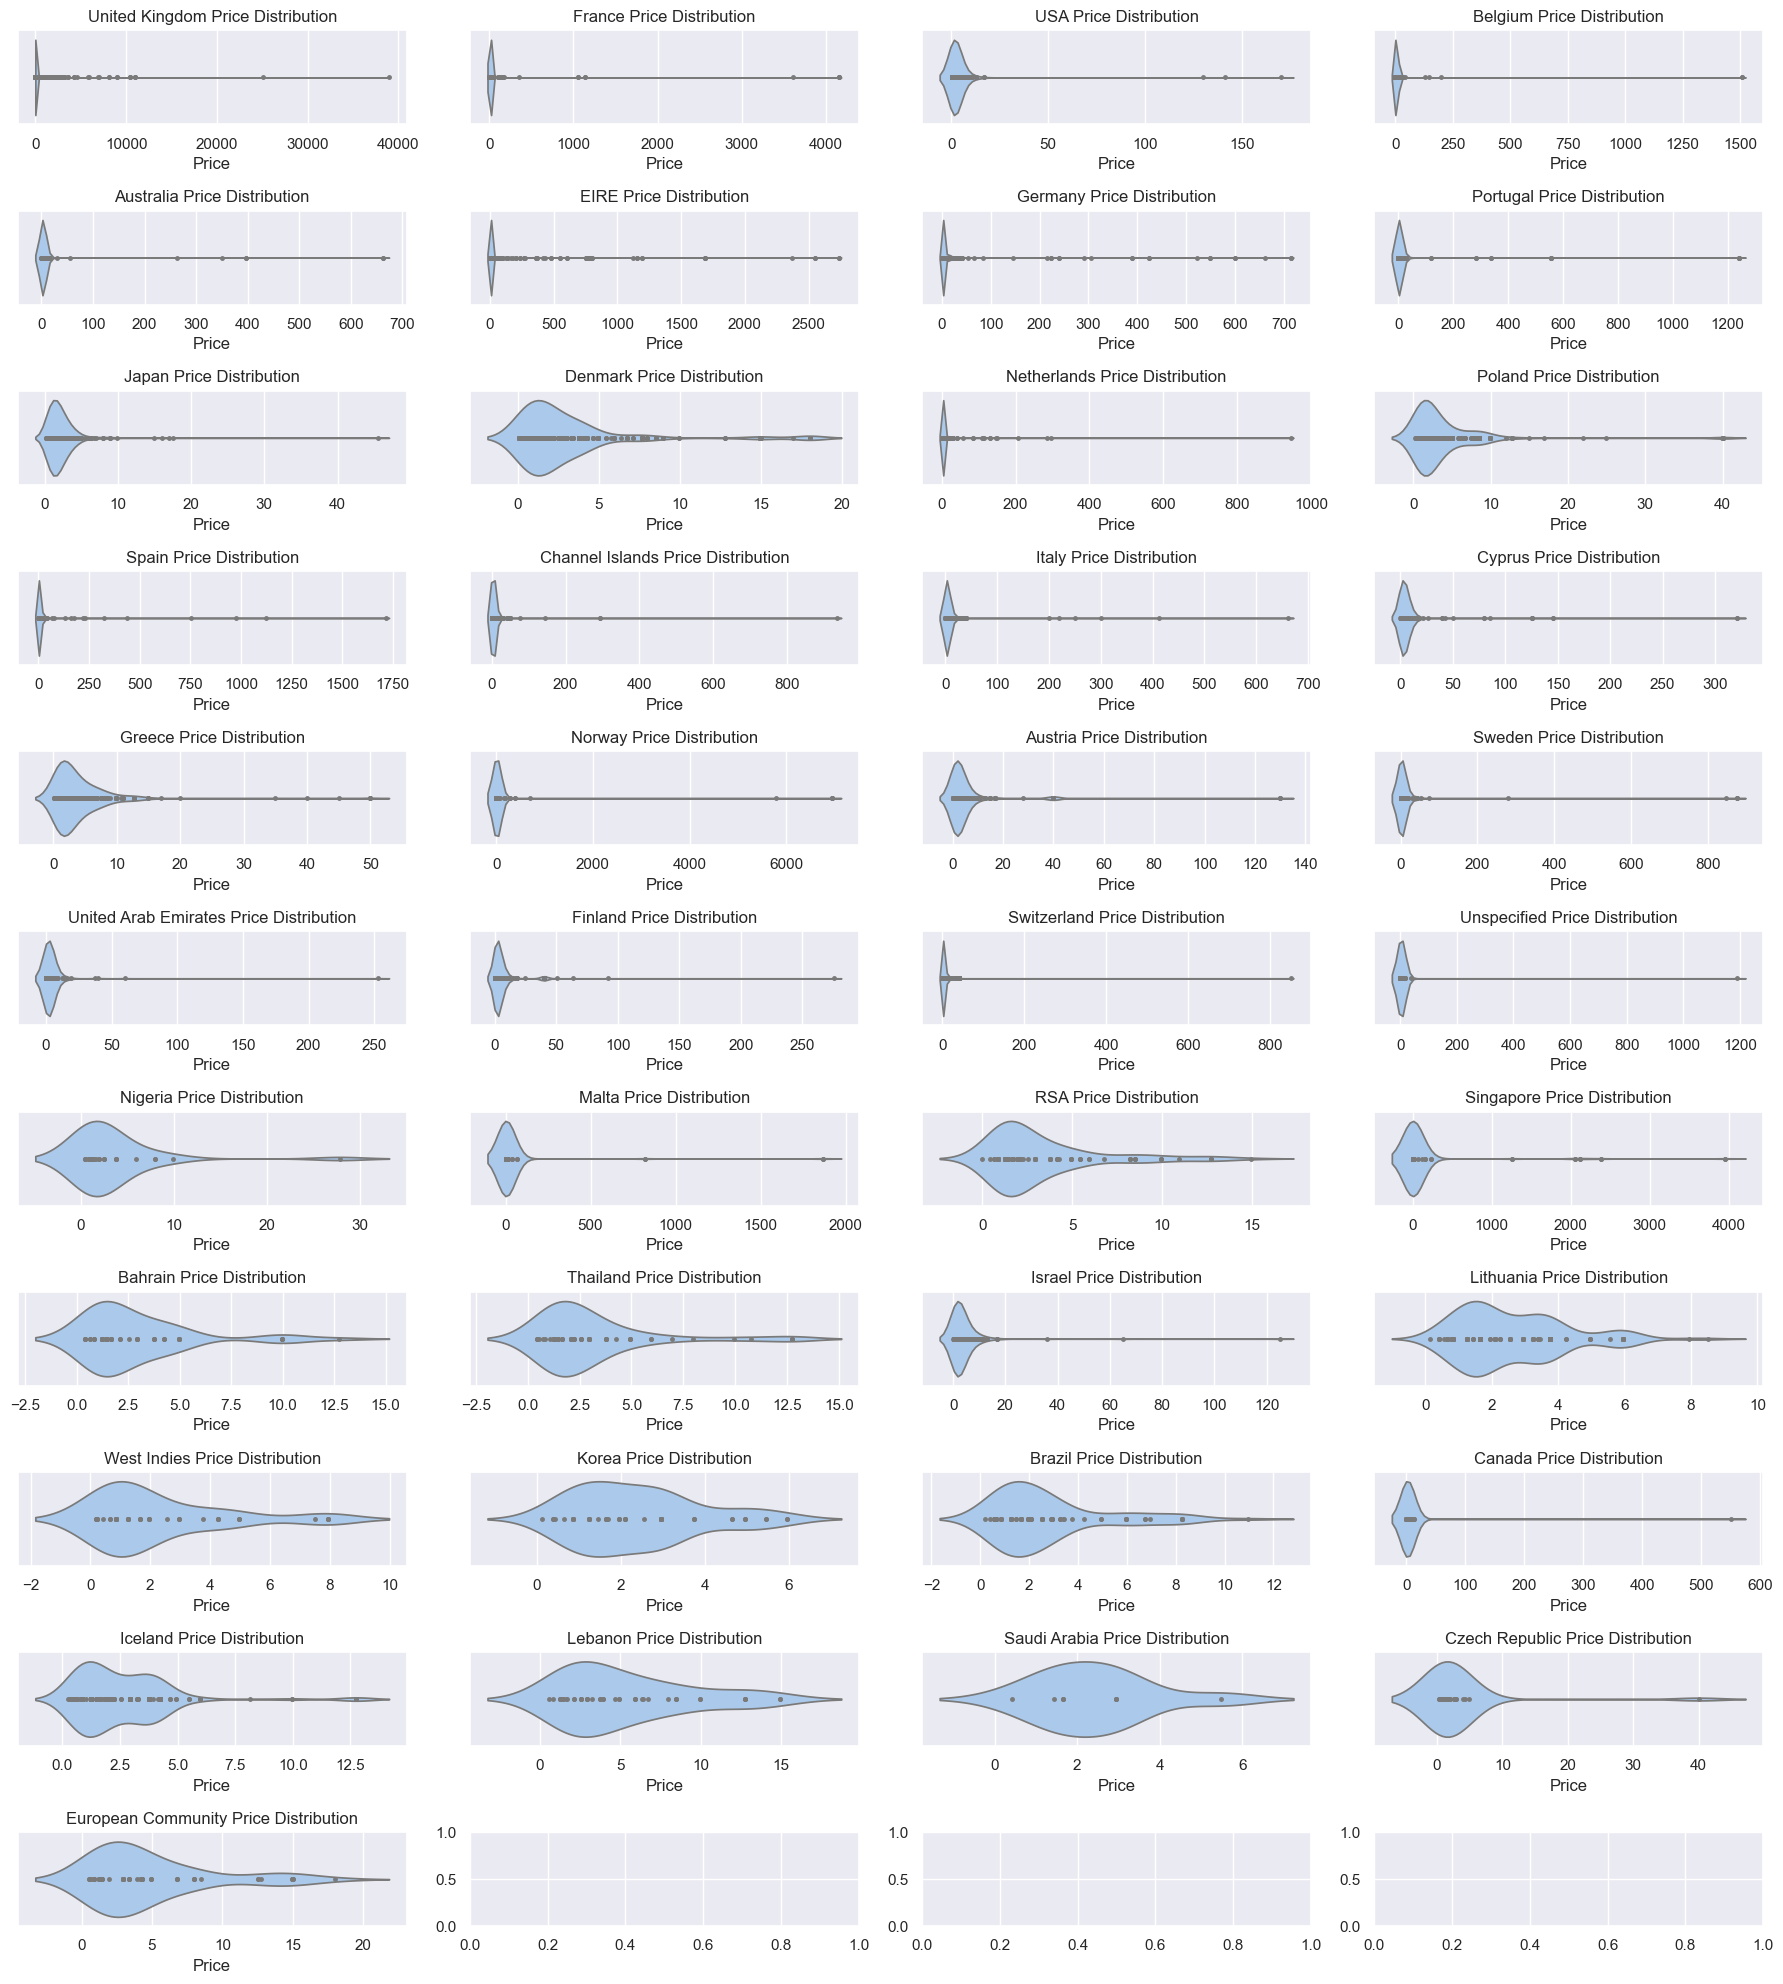

In [28]:
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "Price", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

In [29]:
# No of Unique Invoices

len(data["Invoice"].unique())

44876

In [30]:
temp_invoice_df = data.select_dtypes(exclude=['datetime64']).groupby('Invoice').sum()
temp_invoice_df.head(10)

,StockCode,Description,Quantity,Price,Customer ID,Country
Invoice,,,,,,
489434,352425,15CM CHRISTMAS GLASS BALL 20 LIGHTSPINK CHERRY...,166,32.65,104680.0,United KingdomUnited KingdomUnited KingdomUnit...
489435,89247,"CAT BOWL DOG BOWL , CHASING BALL DESIGNHEART M...",60,10.50,52340.0,United KingdomUnited KingdomUnited KingdomUnit...
489436,704982,DOOR MAT BLACK FLOCK LOVE BUILDING BLOCK WORDH...,193,70.88,248482.0,United KingdomUnited KingdomUnited KingdomUnit...
489437,643391,CHRISTMAS CRAFT HEART DECORATIONSCHRISTMAS CRA...,145,83.45,353326.0,United KingdomUnited KingdomUnited KingdomUnit...
489438,994040,DINOSAURS WRITING SET SET OF MEADOW FLOWER S...,826,44.05,307734.0,United KingdomUnited KingdomUnited KingdomUnit...
489439,698182,CHRISTMAS PUDDING TRINKET POT BAKING SET 9 PIE...,219,67.64,240958.0,FranceFranceFranceFranceFranceFranceFranceFran...
489440,44699,"CAT BOWL DOG BOWL , CHASING BALL DESIGN",16,6.30,36174.0,United KingdomUnited Kingdom
489441,150599,BIRD DECORATION RED SPOTBAKING SET 9 PIECE RET...,102,12.17,72348.0,United KingdomUnited KingdomUnited KingdomUnit...
489442,755792,UNION JACK GUNS & ROSES DOORMATSCOTTIE DOG HO...,275,46.94,313605.0,United KingdomUnited KingdomUnited KingdomUnit...


In [31]:
temp_invoice_df.reset_index(inplace = True)

Top 30 invoices with total quantity purchased by them

In [32]:
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

,Invoice,StockCode
13782,518505,1900358
16579,524174,1900358
3830,497946,1048893
44838,581483,23843
25017,541431,23166
5470,501534,258626
2657,495194,308337
5860,502269,87927
2013,493819,3382258
1309,491812,2958708


Top 15 Invoices with average prices sorted from high to low

In [33]:
data["Price"] = pd.to_numeric(data["Price"], errors='coerce')
data.groupby(["Invoice"])["Price"].mean().head(15).sort_values(ascending=False)

Invoice
489444    141.000000
489447    130.000000
489434      4.081250
489436      3.730526
489437      3.628261
489439      3.560000
489440      3.150000
489446      3.118519
489441      3.042500
489448      2.970000
489435      2.625000
489438      2.591176
489445      2.477895
489443      2.370000
489442      2.040870
Name: Price, dtype: float64

I have grouped the data by Invoice to see the average spend by Invoice Number. Here one thing interesting to see that the invoice with number **489444** & **489447** has outspent others. So to gain some better clarity, let's check these 2 invoices and get insights on how much quantity they have purchased so far.

In [34]:
data[(data["Invoice"] == 489444) | (data["Invoice"] == 489447)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,0,POSTAGE,1,2009-12-01 09:55:00,141.0,12636.0,USA
173,489447,0,POSTAGE,1,2009-12-01 10:10:00,130.0,12362.0,Belgium


As you can see above, These 2 invoices with invoice number **489444** and **489447** had only single transaction, that's why the average price was too high.

### **INITIAL EDA INSIGHTS:**

1) Most of the customers are from the United Kingdom followed by the Germany, EIRE & France.

2) If we check the average price sale by countries, what we have observed is that Singapore has the highest averge price sale followed by the Norway and Malta.

3) Most of the countries data is skewed when it comes to the Price feature with lots of higher extreme values.

4) There are total 44876 uniques purchased happend so far.

5) We have also observed some of the Invoices who have purchased most of the quantities within 2 year of span.

6) When it comes to the average spend there are 2 invoices with number 489444 and 489447 having the highest average spent but upon inspection we also found the average product purchase was only 1 which is from USA followed by Belgium.

Let's look at the data once again & see what else insights we can get from the data itself

In [35]:
data.head(15)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


Check for which product has been purchased more often so far

<Axes: xlabel='Description'>

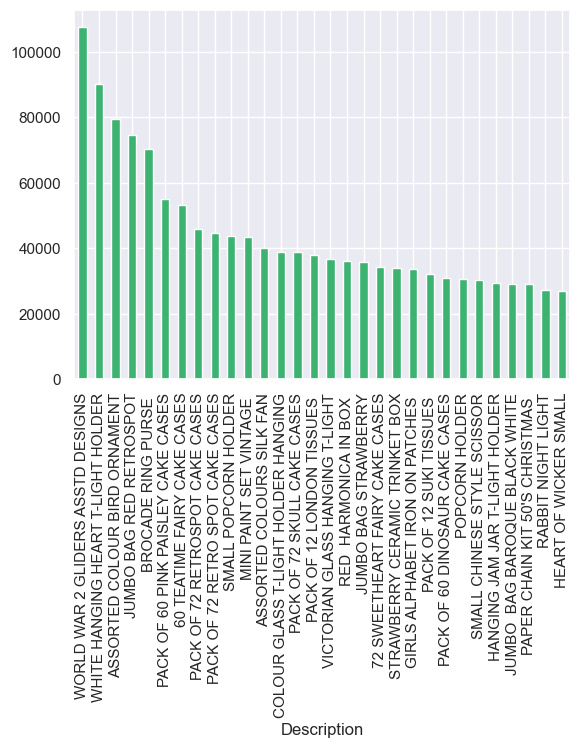

In [36]:
data.groupby("Description").agg({'Quantity': 'sum'}).sort_values(
    by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar", color = 'mediumseagreen')

Create a data copy point and adding some extra columns to data

In [37]:
temp_data = data.copy()

In [38]:
temp_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


**Date Time Analysis**

In [39]:
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek

**Mapping days of Week**

In [40]:
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

**Using map function renaming the data values**

In [41]:
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping)

In [42]:
temp_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Time,Year,Day,Quarter,Day of Week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12,12:50:00,2011,9,4,Friday
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,12,12:50:00,2011,9,4,Friday


**Plotting the above data**

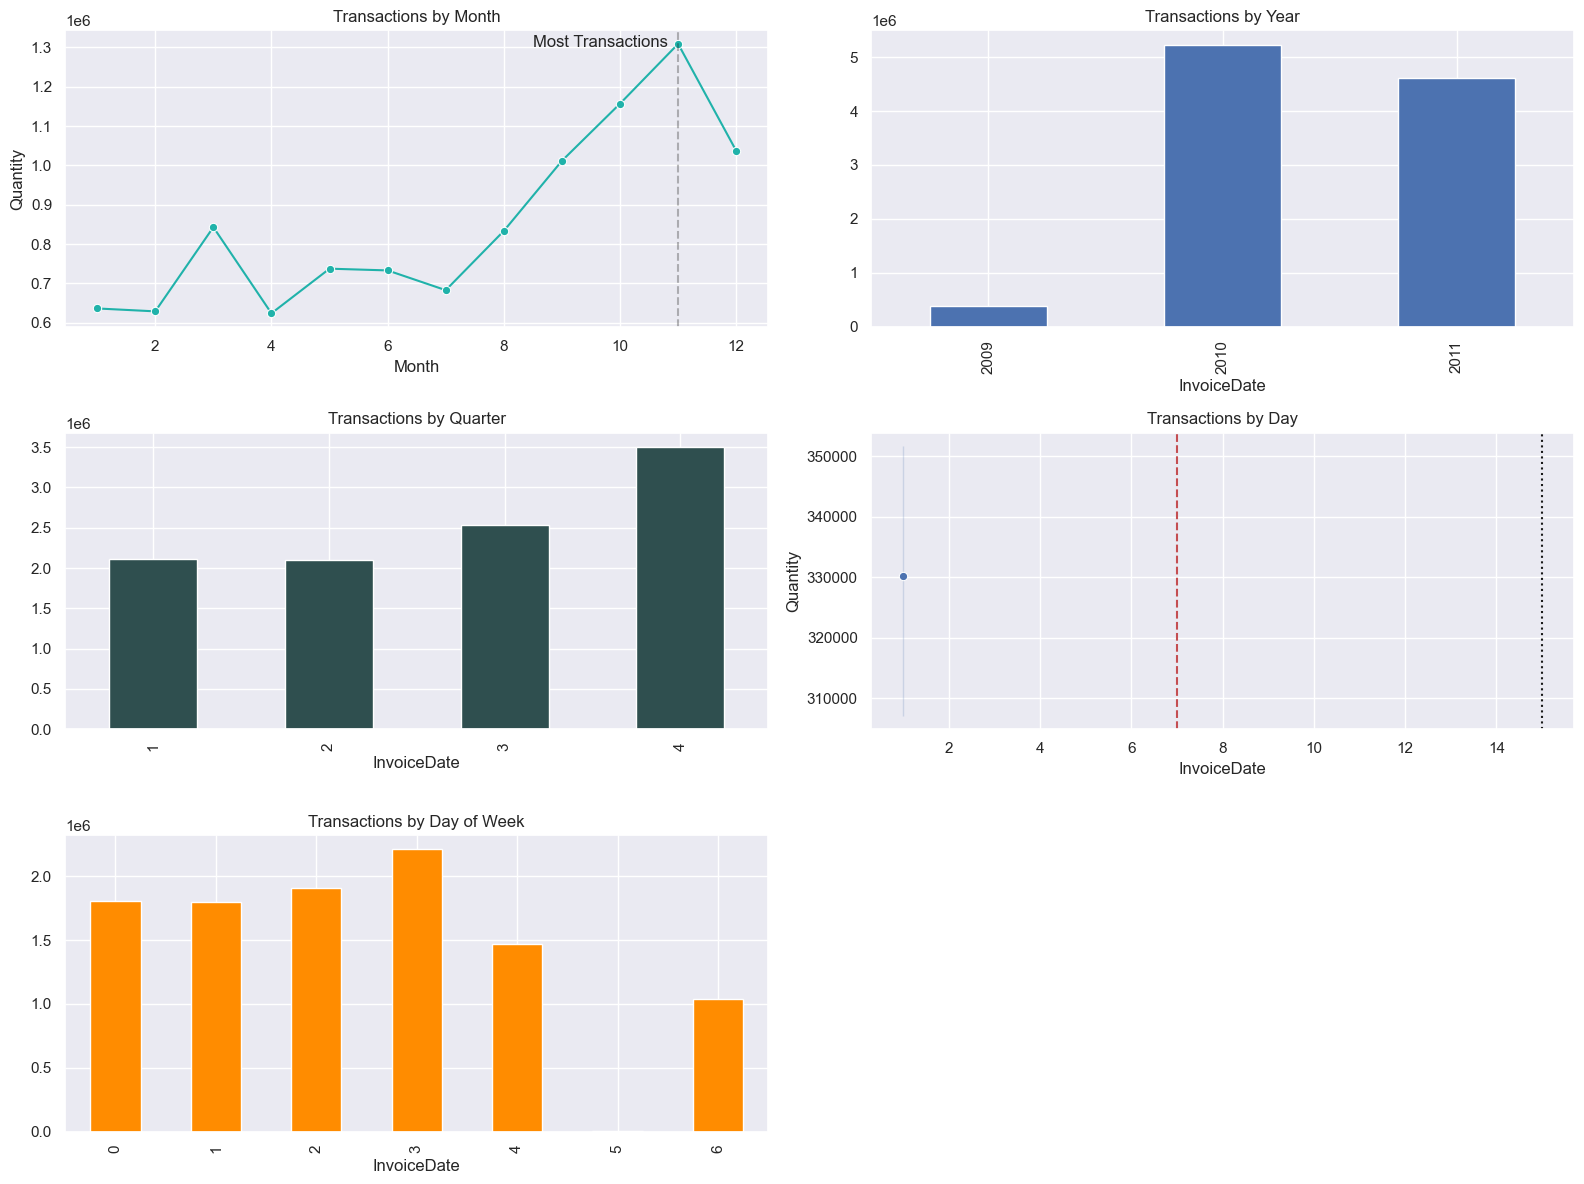

In [43]:
plt.figure(figsize=(16,12))

# Plotting Transactions by Month
plt.subplot(3,2,1)
temp_data["Month"] = temp_data["InvoiceDate"].dt.month
sns.lineplot(x="Month", y="Quantity", data=temp_data.groupby("Month")["Quantity"].sum().reset_index(), marker="o", color="lightseagreen")
plt.axvline(11, color="k", linestyle='--', alpha=0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")

# Plotting Transactions by Year
plt.subplot(3,2,2)
temp_data.groupby(temp_data["InvoiceDate"].dt.year)["Quantity"].sum().plot(kind="bar")
plt.title("Transactions by Year")

# Plotting Transactions by Quarter
plt.subplot(3,2,3)
temp_data.groupby(temp_data["InvoiceDate"].dt.quarter)["Quantity"].sum().plot(kind="bar", color="darkslategrey")
plt.title("Transactions by Quarter")

# Plotting Transactions by Day of Month
plt.subplot(3,2,4)
sns.lineplot(x=temp_data["InvoiceDate"].dt.day, y="Quantity", data=temp_data.groupby(temp_data["InvoiceDate"].dt.day)["Quantity"].sum().reset_index(), marker="o")
plt.axvline(7, color='r', linestyle='--')
plt.axvline(15, color='k', linestyle="dotted")
plt.title("Transactions by Day")

# Plotting Transactions by Day of Week
plt.subplot(3,2,5)
temp_data.groupby(temp_data["InvoiceDate"].dt.dayofweek)["Quantity"].sum().plot(kind="bar", color="darkorange")
plt.title("Transactions by Day of Week")

plt.tight_layout()
plt.show()


As we can see, in 2009 the transactions is quite low as compared to 2010 and 2011. But as if now, we don't know the reason behind this so let's investigate why 2009 is low as compared to other 2 years.

In [44]:
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2009]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2009]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2010: {}".format(len(temp_data[temp_data["Year"] == 2010]["Country"].unique())))
print("Total Number of Transactions in 2010: {}".format(temp_data[temp_data["Year"] == 2010]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2011: {}".format(len(temp_data[temp_data["Year"] == 2011]["Country"].unique())))
print("Total Number of Transactions in 2011: {}".format(temp_data[temp_data["Year"] == 2011]["Quantity"].sum()))

Total Number of Countries in 2009: 23
Total Number of Transactions in 2009: 390286
--------------------------------------------
Total Number of Countries in 2010: 37
Total Number of Transactions in 2010: 5233315
--------------------------------------------
Total Number of Countries in 2011: 36
Total Number of Transactions in 2011: 4610527


Through this analysis what conclusion we can make is that may be the company has started their operations in other countries and started to expand their business further.

##### Filtering the DataFrame to include only Data from the particular year

In [45]:
_2009 = temp_data[temp_data["Year"] == 2009]["Country"].unique()
_2010 = temp_data[temp_data["Year"] == 2010]["Country"].unique()
_2011 = temp_data[temp_data["Year"] == 2011]["Country"].unique()

Check for Country which were available in 2010 and 2011 but not 2009

In [46]:
no_cols = []

for i in (_2010):
    if i not in _2009:
        no_cols.append(i)
print("These are the values which are not present in 2009: {}".format(no_cols))

These are the values which are not present in 2009: ['Unspecified', 'Nigeria', 'Malta', 'RSA', 'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland']


In [47]:
temp = data.groupby(["Country", "Description"], as_index=False)["Quantity"].sum()

In [48]:
temp = pd.DataFrame(temp)

### Top 8 countries with popular products

In [49]:
top_8_countries = ["United Kingdom", "Netherlands", "EIRE", "Denmark", "Germany", "France", "Australia", "Sweden"]

In [50]:
top_8_countries

['United Kingdom',
 'Netherlands',
 'EIRE',
 'Denmark',
 'Germany',
 'France',
 'Australia',
 'Sweden']

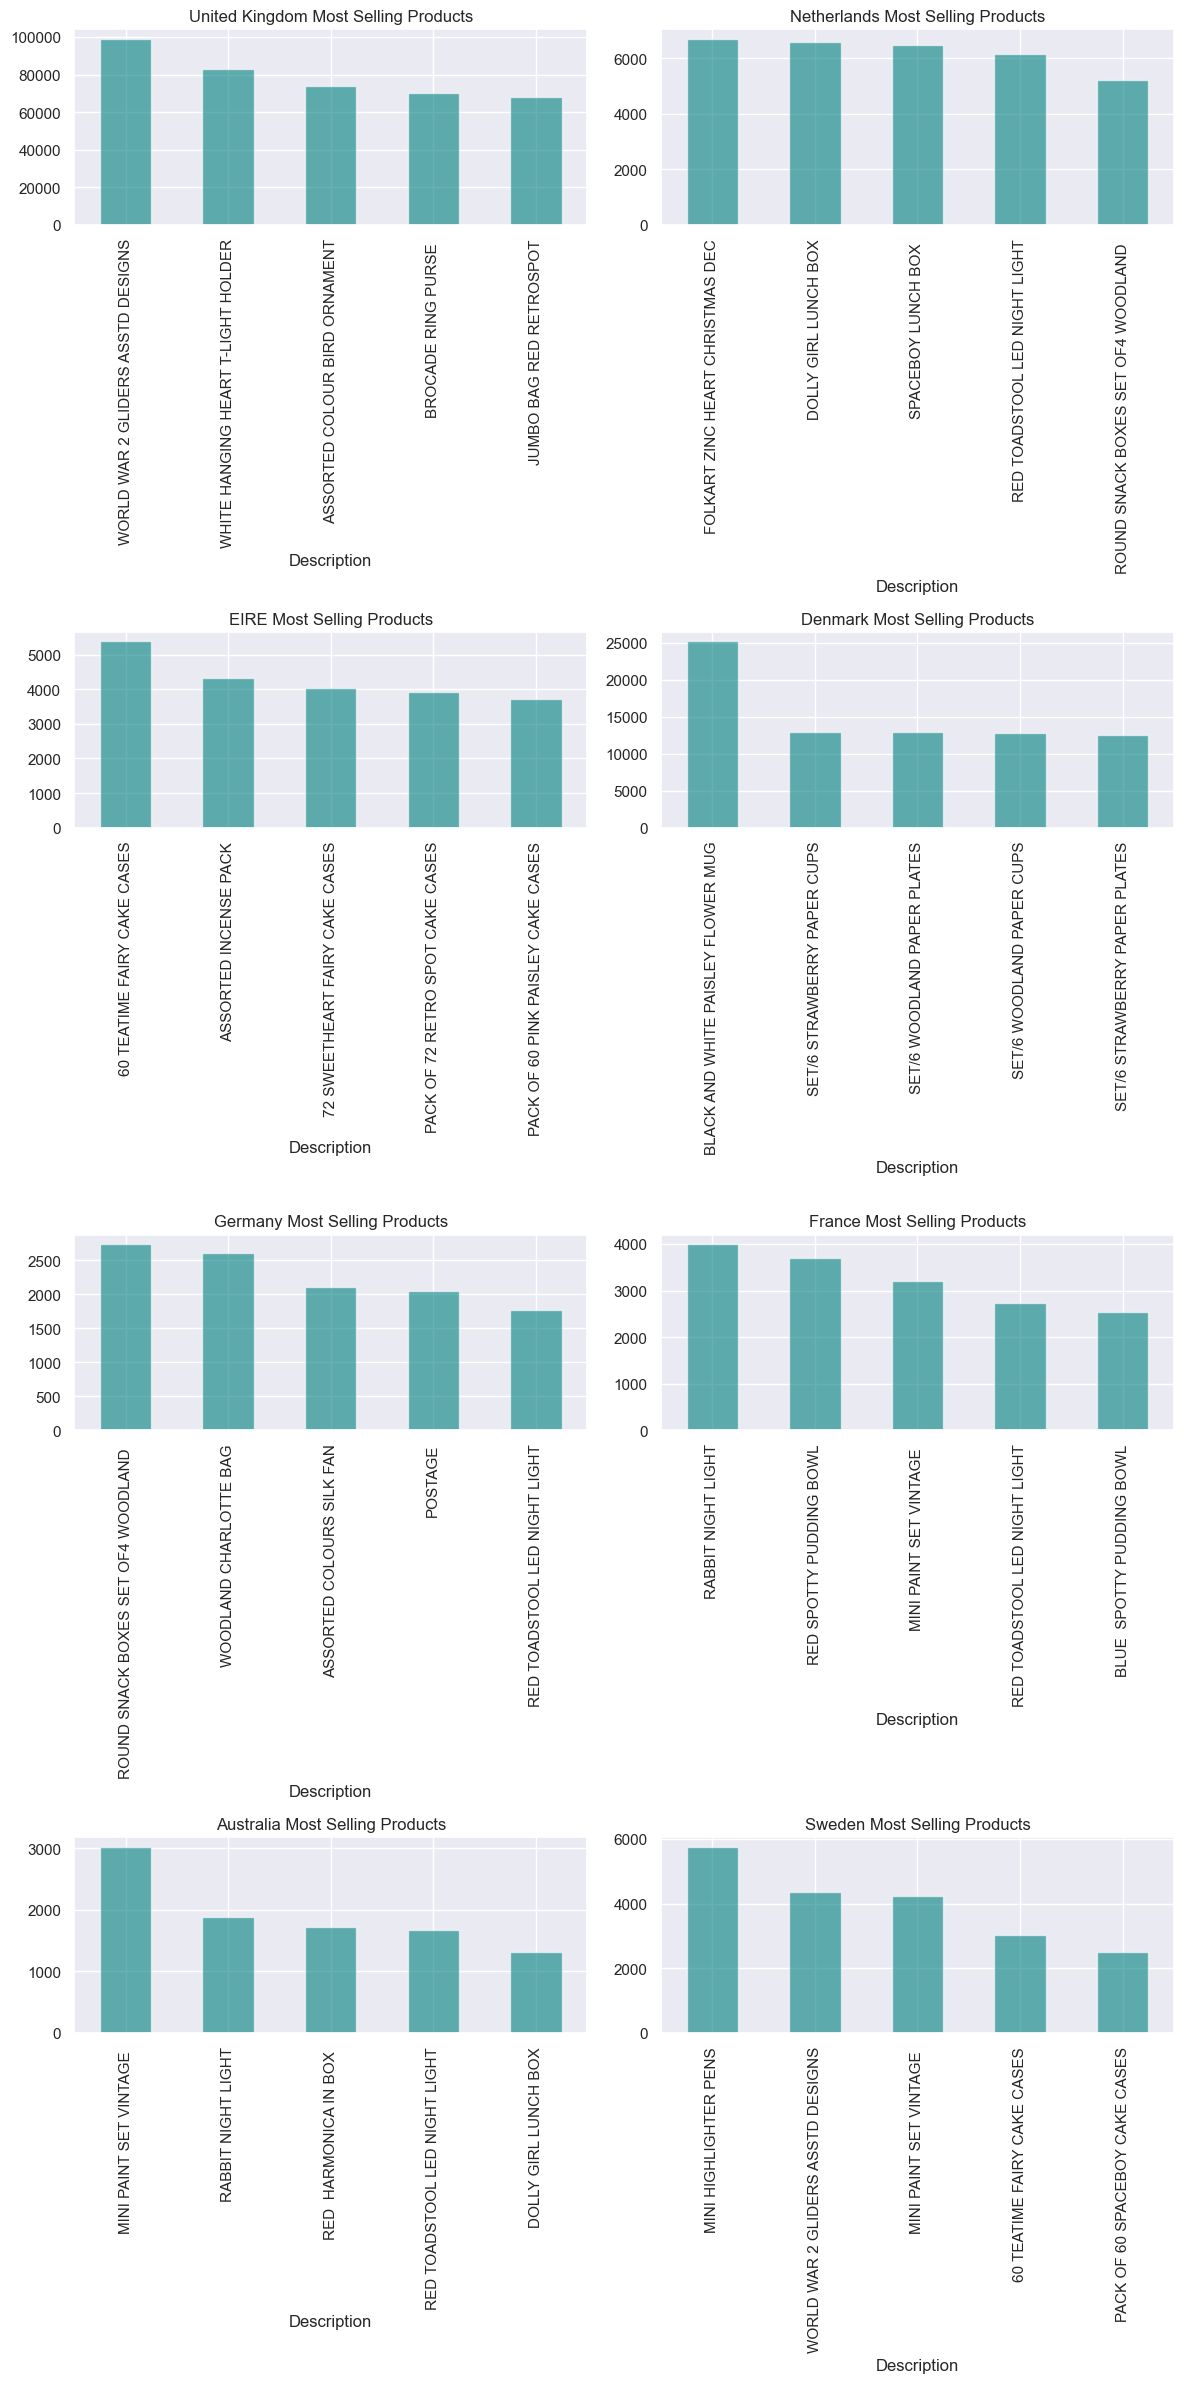

In [51]:
plt.figure(figsize=(12,24))
for i, country in enumerate(top_8_countries):
    ax = plt.subplot(4,2, i+1)
    plt.title(country + ' '+ "Most Selling Products")
    temp_data[temp_data["Country"] == country].groupby("Description")["Quantity"].sum().nlargest(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()
plt.show()

### 8 Countries which are at bottom with Mostly Purchased Products

In [52]:
least_8_country = ["Saudi Arabia", "Nigeria", "Lebanon", "West Indies", "European Community", "Brazil", "Czech Republic", "Korea"]

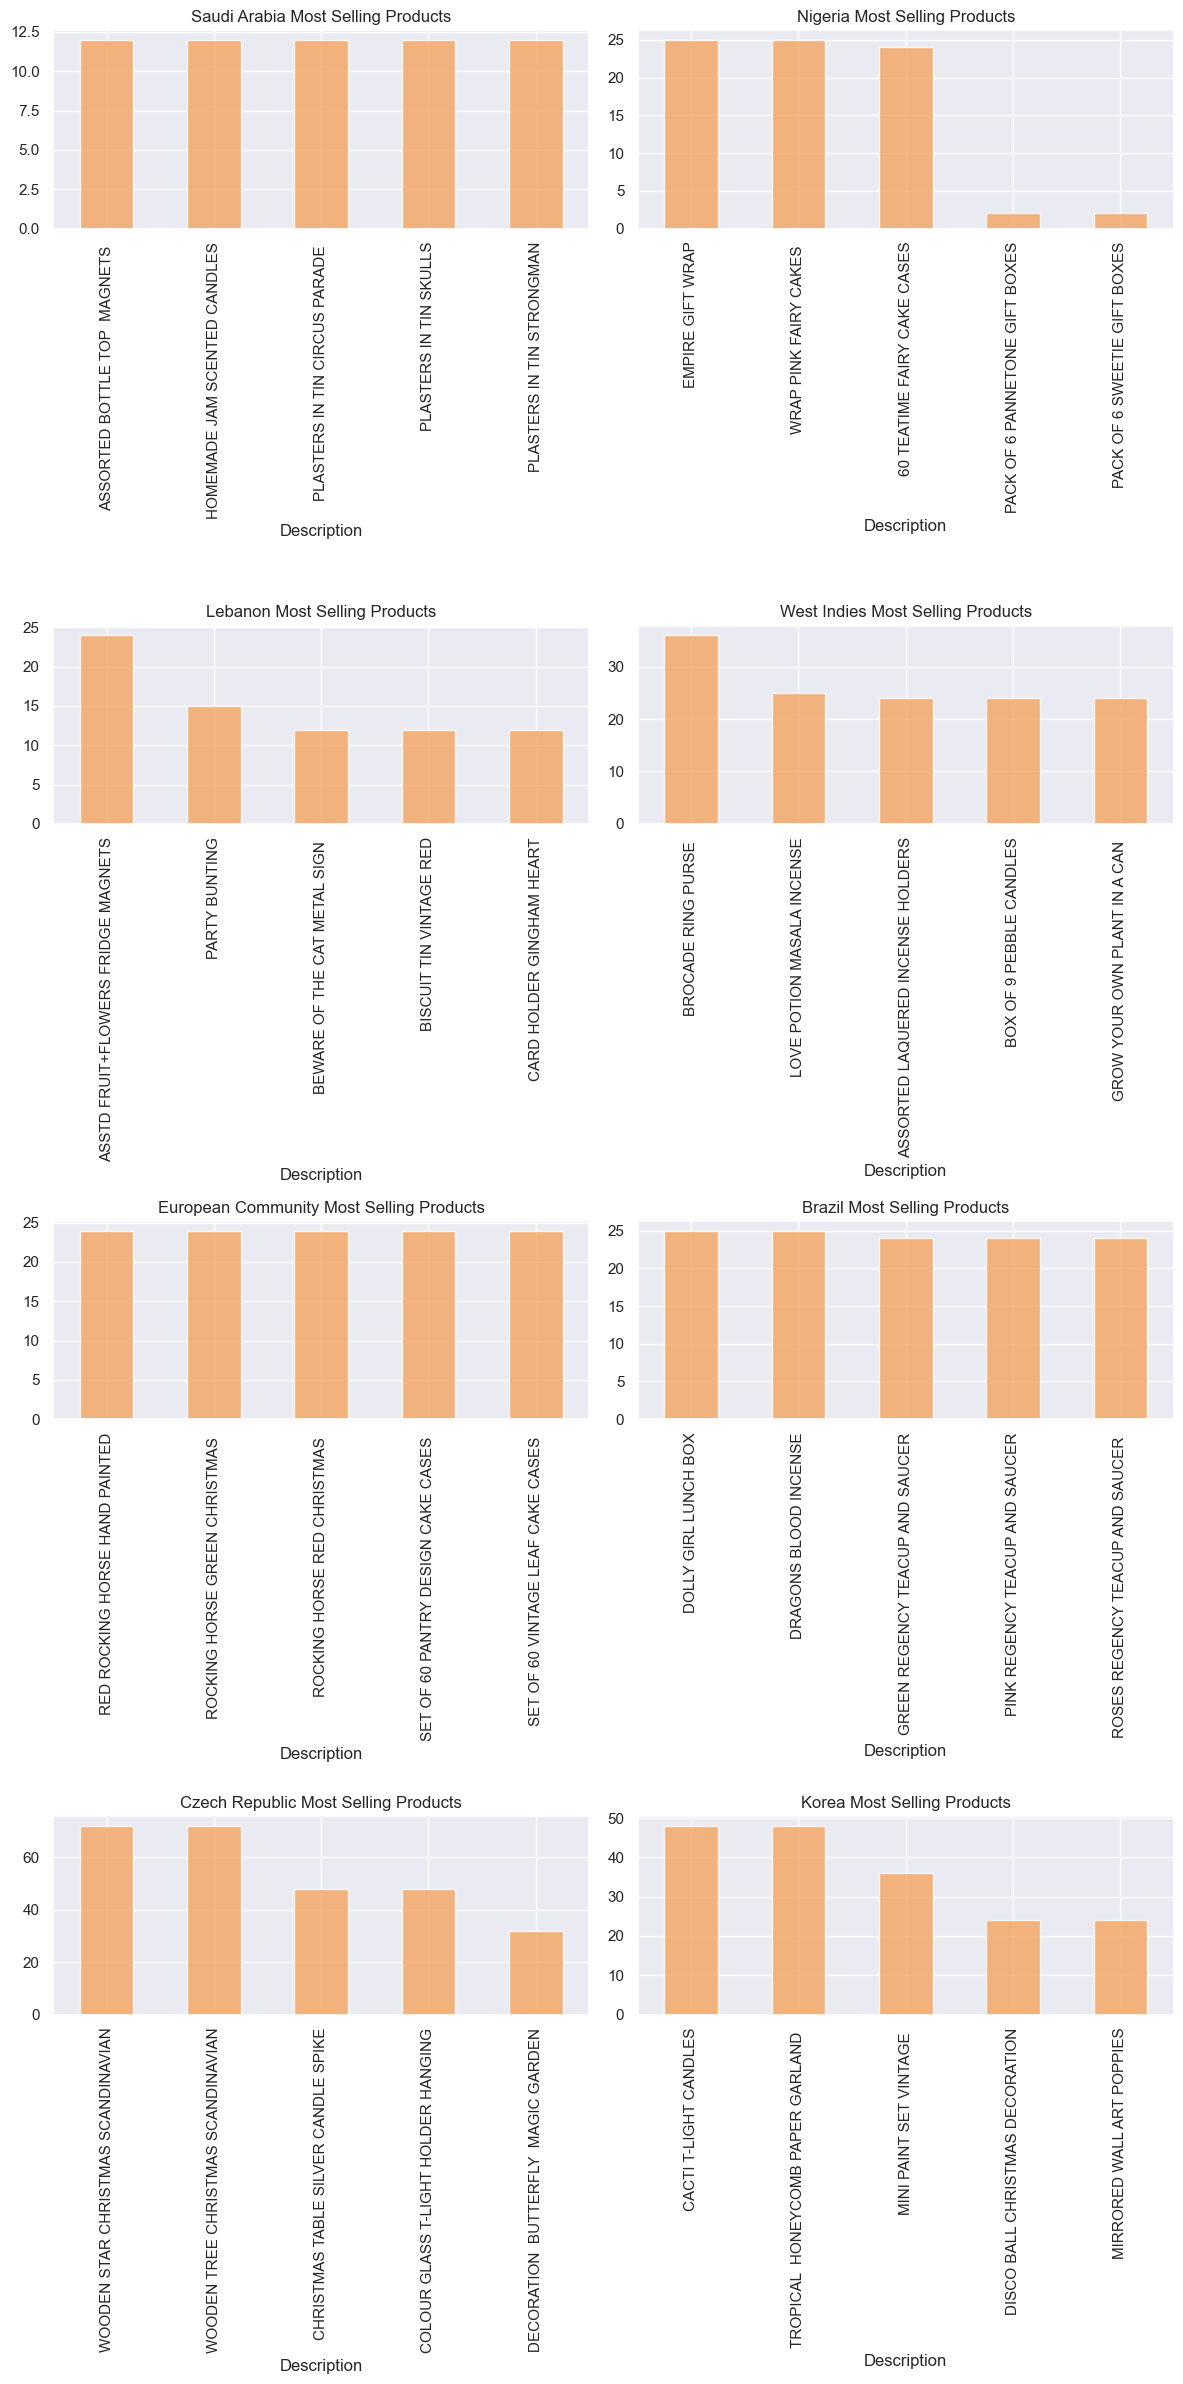

In [53]:
plt.figure(figsize=(12,24))
for i, country in enumerate(least_8_country):
    ax = plt.subplot(4,2, i+1)
    plt.title(country + ' '+ "Most Selling Products")
    temp_data[temp_data["Country"] == country].groupby("Description")["Quantity"].sum().nlargest(5).plot(kind = "bar", ax = ax, color = "sandybrown", alpha = 0.8)
    plt.tight_layout()
plt.show()

### **EDA INSIGHTS:**


1) Our Top 5 Best Selling Products are **World War 2 Gliders**, **White Hanging Heart**, **Assorted Colour Bird**, **Jumbo Bag Red**, **Brocade Ring**.

2) Most Transactions happened in the month of Novemeber which is evident due to festive seasons.

3) 2010 is the year in which we have the most transactions followed by the 2011

4) Q4 being the highest when it comes transactions.

5) It also observed that in the end of the 1st week and starting of the 3rd week, people tends to buy more.

6) People loves to shop on Thursday followed by Tuesday and Wednesday.


### RFM Estimation - (Recency, Frequency, Monetary)

RFM stands for frequency, recency & monetary is a marketing technique which is used to find the best customers by analyzing their past purchasing behavior. It includes how frequently they have purchased, what is the total amount that they have spend so far, what was the last time they have purchased from our online store so on & so forth.....

In [54]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [55]:
data["Total Amount"] = data["Quantity"]*data["Price"]

Calculating the recency, frequency, T, monetary_value

In [56]:
summary = lifetimes.utils.summary_data_from_transaction_data(data, "Customer ID", "InvoiceDate", "Total Amount")

In [57]:
#resetting the index
summary = summary.reset_index()

In [58]:
summary.shape

(5942, 5)

In [59]:
idx = summary[summary["monetary_value"] <= 0].index
summary = summary.drop(idx, axis = 0).reset_index().drop("index", axis = 1)
print("Total Number of Negative Values: %s" % (len(summary[summary["monetary_value"] < 0]))) 

Total Number of Negative Values: 0


A) **T** -  T is the length of the period of observation for the customer based on the value used for freq (the default is frequency is day). This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq.

B) **Recency** - Recency is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq.

C) **Frequency** - Frequency is the number of repeat purchases the customer made during the observation period.

D) **Monetary** - monetary_value is the average monetary amount of each repeat purchase made by a customer.

In [60]:
summary.head()

,Customer ID,frequency,recency,T,monetary_value
0,12347.0,7.0,402.0,404.0,717.398571
1,12348.0,4.0,363.0,438.0,449.310000
2,12349.0,4.0,717.0,735.0,1107.172500
3,12352.0,8.0,356.0,392.0,218.182500
4,12353.0,1.0,204.0,408.0,89.000000


Plotting the distribution for frequency recency and T distribution

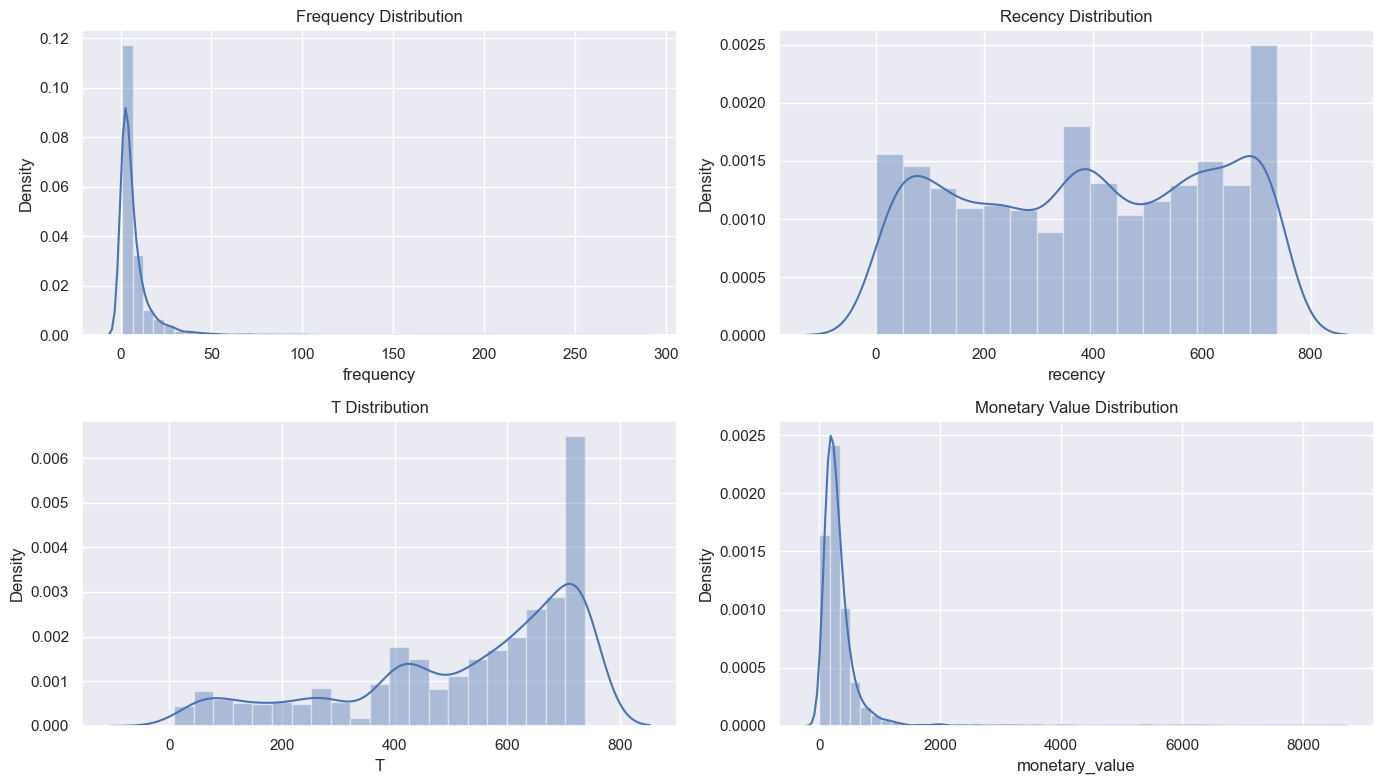

In [61]:
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

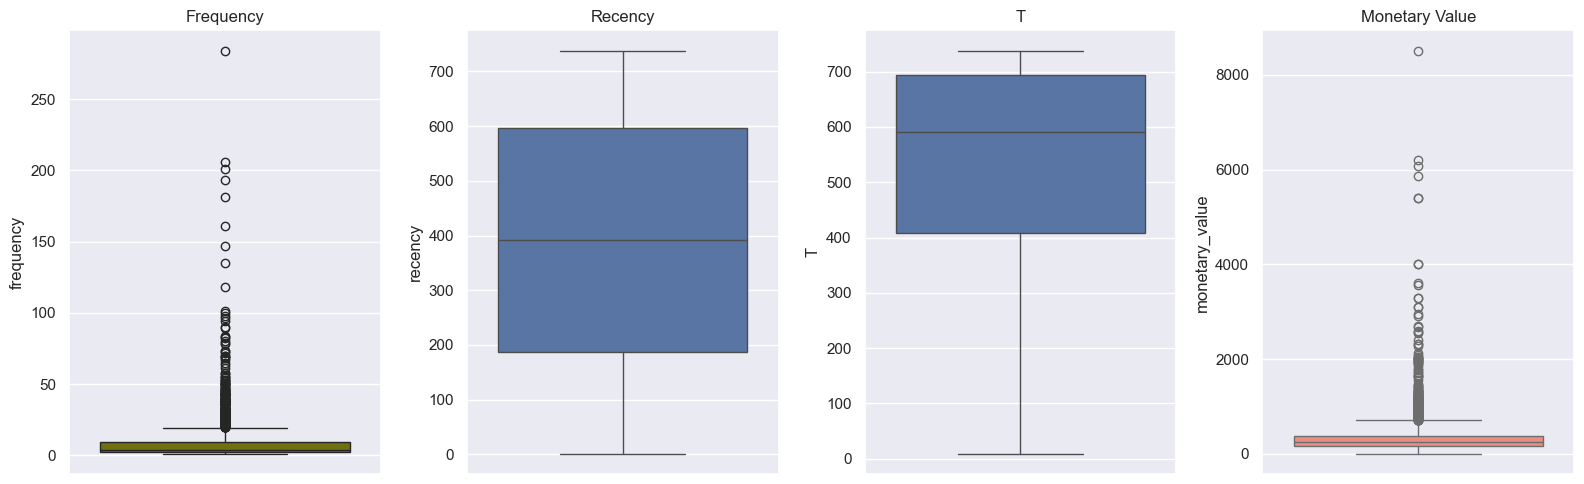

In [62]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(summary["monetary_value"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()

In [63]:
summary.describe()

,Customer ID,frequency,recency,T,monetary_value
count,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000
mean,15300.610036,7.710394,389.019594,525.313978,330.660850
std,1699.142670,12.811259,227.696105,203.847691,380.343579
min,12347.000000,1.000000,1.000000,9.000000,1.150000
25%,13834.000000,2.000000,187.000000,409.000000,160.876000
50%,15288.000000,4.000000,392.000000,591.000000,247.690000
75%,16771.000000,9.000000,596.000000,694.000000,381.096667
max,18287.000000,284.000000,738.000000,738.000000,8513.271143


Checking for the values containing zero.

In [64]:
# #checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(summary[summary["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(summary[summary["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(summary[summary["monetary_value"] == 0])))

Total Number of Frequency with 0: 0
Total Number of Recency with 0: 0
Total Number of Monetary Value with 0: 0


Now we have the data related to the RFM, we can now start with which model we can build to predict our customer's lifetime value. First we have to figure out either we have to do the prediction based on the customer level or the aggregate level.

For this analysis I am using to predict the customer lifetime value on the customer level rather than the aggregate or a cohort level.

Before building the model, we have to understand few of the most important things. We have to understand the business context that is the type of customers **(contractual or non-contractual)** and their purchase opportunity **(discrete or continuous)**. The combination of both defines the business context which going to affect our CLV estimation approach.

**Basic Terms:**

a) **Contractual Customers** - Contractual customers are subscription based customers. They churned on a defined date if they choose not to renew the subscription.

b) **Non-Contractual Customers** -  Non Contractual customers generally exist in e-commerce or retail business where there's no defined time period when the customer is going to churn.

c) **Continuous Purchase** - It refers to the time period when the customer purchase a certain thing in any time period. Ex- Retail & E-commerce.

d) **Discrete Purchase** - It refers to the time period when the customer purchase a certain thing on a specific time period. Ex - Netflix, Hulu, Hotstar Subscription.

For this analysis we are going to use the non-contractual with continuous purchase opportunity and the best fitted models we are going to use will be BG-NBD Model, Pareto-NBD Model, Modifies BG Model along with Gamma Gamma Distribution model for estimating the expected monetary value as a part of the customer lifetime value prediction.

## Beta Geo - Negative Binomial Distribution + Gamma Gamma Distribution Model

In [65]:
summary_bgf = summary.copy()

In [66]:
summary_bgf.head(2)

,Customer ID,frequency,recency,T,monetary_value
0,12347.0,7.0,402.0,404.0,717.398571
1,12348.0,4.0,363.0,438.0,449.310000


We can use penalizer of 0.001 or 0.1 which we will be going to use later on based on the model performance and model selection

In [67]:
bgf = BetaGeoFitter(penalizer_coef = 0.0)

In [68]:
bgf.fit(summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

<lifetimes.BetaGeoFitter: fitted with 4185 subjects, a: 0.16, alpha: 85.42, b: 2.46, r: 1.50>

In [69]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.495520,0.039277,1.418537,1.572503
alpha,85.419487,2.596556,80.330237,90.508737
a,0.163455,0.015943,0.132208,0.194703
b,2.463482,0.348952,1.779537,3.147428


In [70]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4185 subjects, a: 0.16, alpha: 85.42, b: 2.46, r: 1.50>


Plotting Frequency and Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

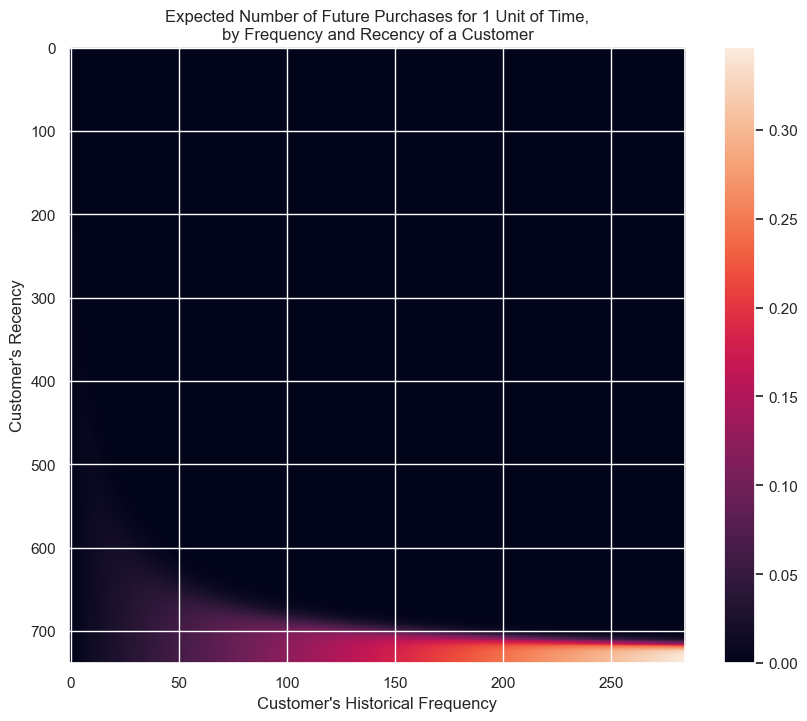

In [71]:
plt.figure(figsize=(10,8))
plot_frequency_recency_matrix(bgf)

Here from matrix we are ablr to find that our best customer is where customer's hostorical frequency is around 250 and customer's recency is 700 

### Plotting Churn Matrix

**It will give % of customers who have net ordered again.**

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

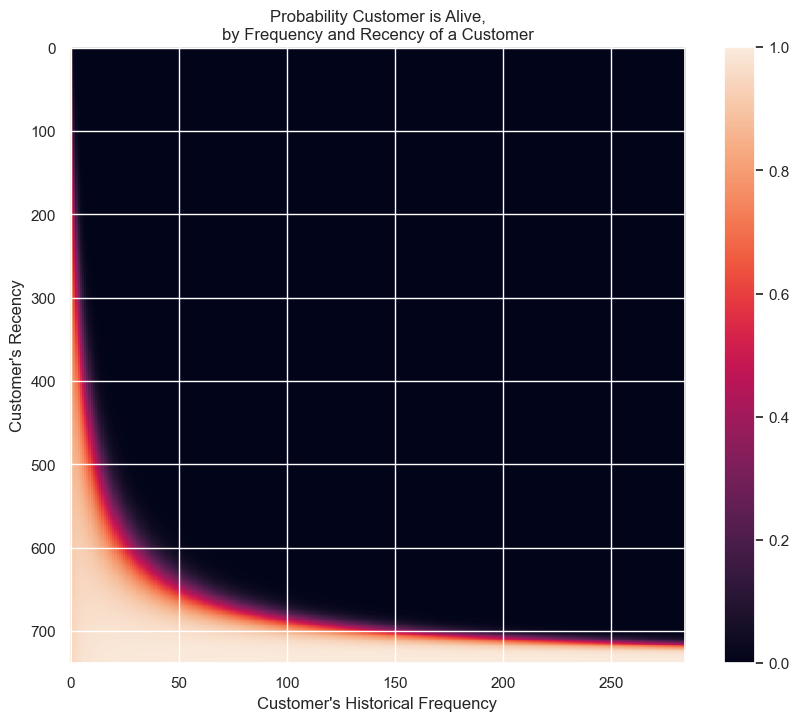

In [72]:
plt.figure(figsize=(10,8))
plot_probability_alive_matrix(bgf)

Here we can see that our 80% customers have already churn.

In [73]:
t = 30
summary_bgf["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

In [74]:
summary_bgf.sort_values(by = "predicted_purchases").tail(5)

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases
1612,14606.0,181.0,735.0,736.0,165.079448,6.638096
3910,17841.0,193.0,736.0,737.0,357.437461,7.066387
2105,15311.0,201.0,738.0,738.0,560.647015,7.350024
275,12748.0,206.0,735.0,735.0,241.501117,7.559117
1824,14911.0,284.0,737.0,738.0,948.996127,10.362659


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

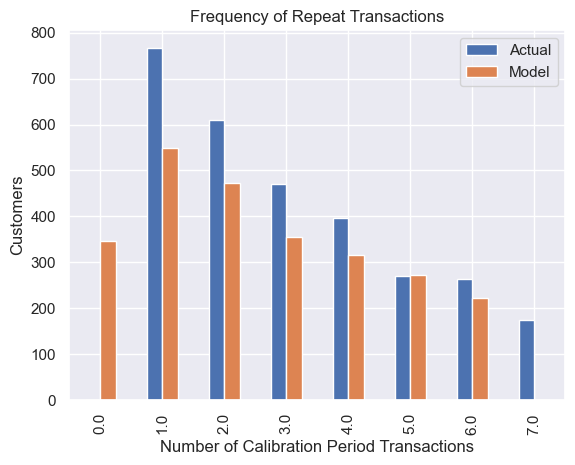

In [75]:
plot_period_transactions(bgf)

We can see that our model is doing fair job. Our model is predicting fairly good at the 1 & 3 calibration time period.

### Dividing our dataset into training & holdout

In [76]:
summary_cal_holdout = calibration_and_holdout_data(data, "Customer ID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [77]:
pd.DataFrame(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


In [78]:
bgf.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 5025 subjects, a: 0.22, alpha: 49.70, b: 2.72, r: 0.67>

In [79]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
...,...,...,...,...,...
18283.0,9.0,458.0,474.0,9.0,184.0
18284.0,1.0,2.0,247.0,0.0,184.0
18285.0,0.0,0.0,476.0,0.0,184.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

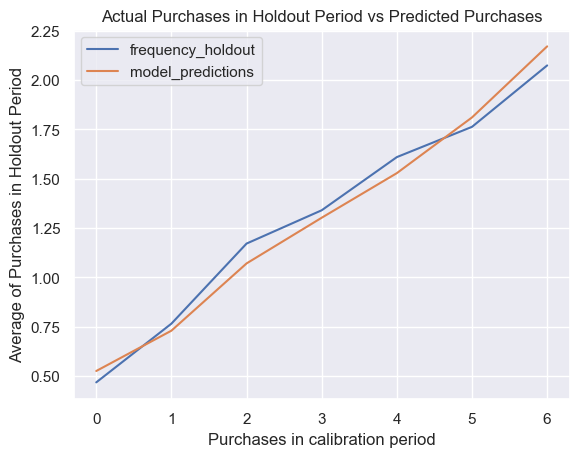

In [80]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

As we can see our model does the decent job while predicting the purchase behaviour.

In [81]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


#### Creating a function which can predict the future purchased value based on the lookup window

In [82]:
def bgf_get_pred_error(t, id_):
    
    individual = summary_bgf[summary_bgf["Customer ID"] == id_]
    
    ind_pred = bgf.predict(t, individual["frequency"], individual["recency"], individual["T"])
    
    actual_val = individual["frequency"]/individual["recency"]*t
    
    error = actual_val - ind_pred
    
    print("Your Predicted Purchase: %s" % (ind_pred))
    print("Your Actual Purchase: %s" % (actual_val))
    print("Prediction Error: %s" % (error))

In [83]:
bgf_get_pred_error(15, 12348.0)

Your Predicted Purchase: 1    0.132161
dtype: float64
Your Actual Purchase: 1    0.165289
dtype: float64
Prediction Error: 1    0.033128
dtype: float64


In [84]:
id_1 = 14606.0
id_2 = 12347.0

In [85]:
days_since_birth = 365

In [86]:
sp_trans_1 = data[data["Customer ID"] == id_1]
sp_trans_2 = data[data["Customer ID"] == id_2]

In [87]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [88]:
# Print the column names in the DataFrame to identify the customer identifier column
print(sp_trans_2.columns)


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Total Amount'],
      dtype='object')


In [89]:
sp_trans_2

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount
423892,529924,22698,PINK REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.70
423893,529924,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.70
423894,529924,20985,HEART CALCULATOR,12,2010-10-31 14:20:00,1.25,12347.0,Iceland,15.00
423895,529924,22418,10 COLOUR SPACEBOY PEN,24,2010-10-31 14:20:00,0.85,12347.0,Iceland,20.40
423896,529924,22422,TOOTHPASTE TUBE PEN,12,2010-10-31 14:20:00,0.65,12347.0,Iceland,7.80
...,...,...,...,...,...,...,...,...,...
1060471,581180,20719,WOODLAND CHARLOTTE BAG,10,2011-12-07 15:52:00,0.85,12347.0,Iceland,8.50
1060472,581180,21265,PINK GOOSE FEATHER TREE 60CM,12,2011-12-07 15:52:00,1.95,12347.0,Iceland,23.40
1060473,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,12347.0,Iceland,13.28
1060474,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,12347.0,Iceland,8.40


In [90]:
sp_trans_2 = data[data["Customer ID"] == id_2]

In [91]:
# plt.figure(figsize=(8,6))
# plot_history_alive(bgf, days_since_birth, sp_trans_2, "InvoiceDate")

In [92]:
# data["InvoiceDate"][0].dtype

In [93]:
sp_trans_1["InvoiceDate"] = pd.to_datetime(sp_trans_1["InvoiceDate"])
sp_trans_2["InvoiceDate"] = pd.to_datetime(sp_trans_2["InvoiceDate"])

sp_trans_1["InvoiceDate"] = sp_trans_1["InvoiceDate"].astype(str)
sp_trans_2["InvoiceDate"] = sp_trans_2["InvoiceDate"].astype(str)

ConversionError: Failed to convert value(s) to axis units: '2009-12-03 12:40:00'

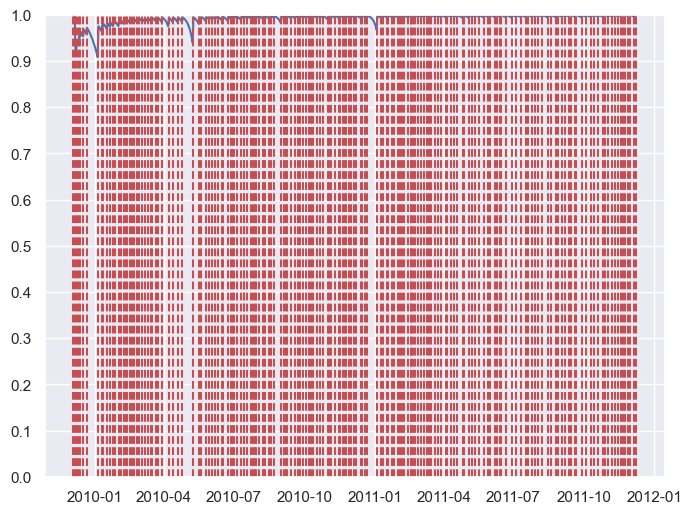

In [95]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_1, "InvoiceDate")     

ConversionError: Failed to convert value(s) to axis units: '2010-10-31 14:20:00'

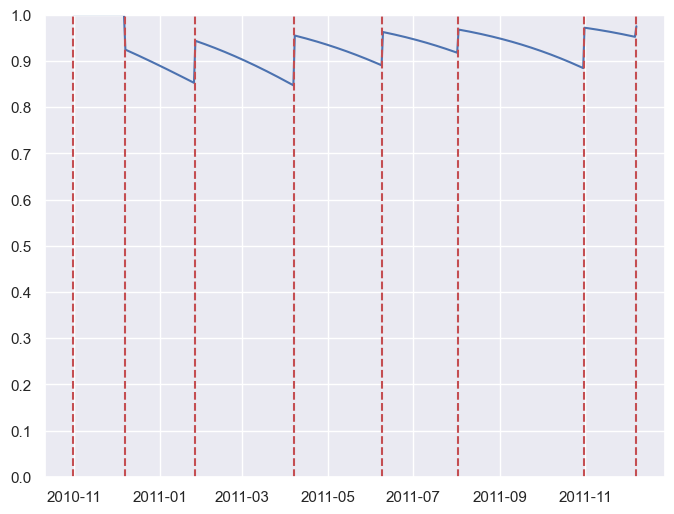

In [96]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_2, "InvoiceDate")

In [97]:
summary_bgf["actual_30"] = summary_bgf["frequency"]/summary_bgf["recency"]*30

In [98]:
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12347.0,7.0,402.0,404.0,717.398571,0.508076,0.522388
1,12348.0,4.0,363.0,438.0,449.310000,0.293052,0.330579
2,12349.0,4.0,717.0,735.0,1107.172500,0.193822,0.167364
3,12352.0,8.0,356.0,392.0,218.182500,0.572890,0.674157
4,12353.0,1.0,204.0,408.0,89.000000,0.120697,0.147059


In [99]:
#calculating the prediction error for the 30 days purchase prediction
summary_bgf["Error"] = summary_bgf["actual_30"] - summary_bgf["predicted_purchases"]

In [100]:
mse = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])

In [101]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_bgf["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 2.475210674157166
Average Error:  0.3596375174364423
Root Mean Squared Error: 1.5732802274728954


#### Purchase Prediction

In [102]:
bgf_mse_purchase_30 = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])
bgf_rmse_purchase_30 = sqrt(bgf_mse_purchase_30)
bgf_avg_error_purchase_30 = summary_bgf["Error"].mean()

In [103]:
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12347.0,7.0,402.0,404.0,717.398571,0.508076,0.522388,0.014312
1,12348.0,4.0,363.0,438.0,449.310000,0.293052,0.330579,0.037527
2,12349.0,4.0,717.0,735.0,1107.172500,0.193822,0.167364,-0.026458
3,12352.0,8.0,356.0,392.0,218.182500,0.572890,0.674157,0.101267
4,12353.0,1.0,204.0,408.0,89.000000,0.120697,0.147059,0.026361


Filtering the data where we have the values of 0 or less than 0.

In [104]:
res_summary = summary_bgf[summary_bgf["frequency"] > 0]

In [105]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

<Axes: >

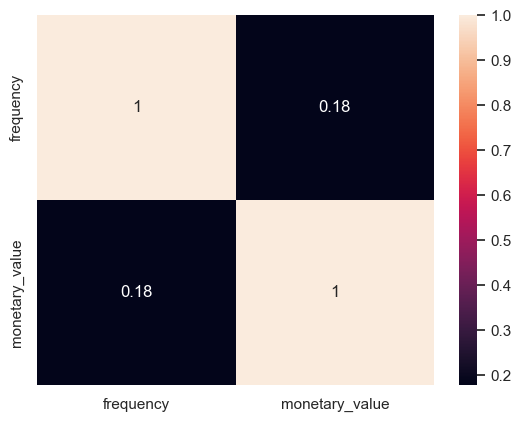

In [106]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

To proceed with the Gamma Gamma Model we have to check for the assumption whether the frequency and monetary values are intercorrelated or not. As we can see here, the correlation between the frequency and monetary value is pretty low so we can go ahead to build Gamma Gamma Model.

In [107]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [108]:
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 1.37, q: 3.86, v: 696.90>

In [109]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.374683,0.058567,1.259892,1.489475
q,3.864415,0.134545,3.600708,4.128123
v,696.904781,50.767856,597.399783,796.409779


In [110]:
summary_bgf.head(2)

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12347.0,7.0,402.0,404.0,717.398571,0.508076,0.522388,0.014312
1,12348.0,4.0,363.0,438.0,449.310000,0.293052,0.330579,0.037527


In [111]:
summary_ = summary_bgf[(summary_bgf["monetary_value"] > 0) & (summary_bgf["frequency"] > 0)]

In [112]:
summary_.shape

(4185, 8)

In [113]:
summary_["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_["frequency"], 
                                                                        summary_["monetary_value"])

In [114]:
summary_.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
0,12347.0,7.0,402.0,404.0,717.398571,0.508076,0.522388,0.014312,629.556290
1,12348.0,4.0,363.0,438.0,449.310000,0.293052,0.330579,0.037527,409.972301
2,12349.0,4.0,717.0,735.0,1107.172500,0.193822,0.167364,-0.026458,842.513995
3,12352.0,8.0,356.0,392.0,218.182500,0.572890,0.674157,0.101267,242.209404
4,12353.0,1.0,204.0,408.0,89.000000,0.120697,0.147059,0.026361,254.858476


In [115]:
print("Expected Average Sales: %s" % summary_["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_["monetary_value"].mean())
print("Difference: %s" % (summary_["monetary_value"].mean() - summary_["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"])))

Expected Average Sales: 340.1889755829264
Actual Average Sales: 330.6608495198251
Difference: -9.528126063101297
Mean Squared Error: 20896.88188078632
Root Mean Squared Error: 144.55753830494734


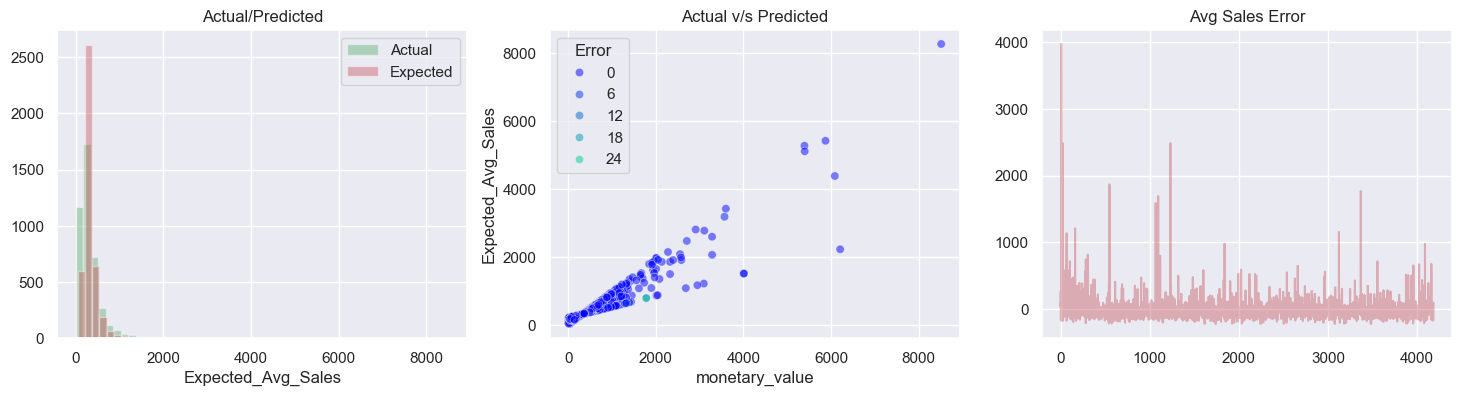

In [116]:
plt.figure(figsize=(18,4))

# Subplot 1: Distribution plot of actual and predicted values
plt.subplot(131)
sns.distplot(summary_["monetary_value"], color="g", kde=False)
sns.distplot(summary_["Expected_Avg_Sales"], color="r", kde=False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])

# Subplot 2: Scatter plot of actual vs predicted values
plt.subplot(132)
sns.scatterplot(x=summary_["monetary_value"], y=summary_["Expected_Avg_Sales"], alpha=0.5, hue=summary_["Error"], palette="winter")
plt.title("Actual v/s Predicted")

# Subplot 3: Plot of average sales error
plt.subplot(133)
plt.plot(summary_["monetary_value"] - summary_["Expected_Avg_Sales"], color='r', alpha=0.4)
plt.title("Avg Sales Error")

plt.show()


In [117]:
summary_["predicted_clv"] = ggf.customer_lifetime_value(bgf,
                                                       summary_["frequency"],
                                                       summary_["recency"],
                                                       summary_["T"],
                                                       summary_["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [118]:
summary_.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
0,12347.0,7.0,402.0,404.0,717.398571,0.508076,0.522388,0.014312,629.556290,7110.166375
1,12348.0,4.0,363.0,438.0,449.310000,0.293052,0.330579,0.037527,409.972301,2512.081673
2,12349.0,4.0,717.0,735.0,1107.172500,0.193822,0.167364,-0.026458,842.513995,3449.798774
3,12352.0,8.0,356.0,392.0,218.182500,0.572890,0.674157,0.101267,242.209404,3100.010138
4,12353.0,1.0,204.0,408.0,89.000000,0.120697,0.147059,0.026361,254.858476,536.035114


In [119]:
# manual calculation of CLV
summary_["predicted_purchases"] * summary_["Expected_Avg_Sales"]

0       319.862625
1       120.143053
2       163.297451
3       138.759354
4        30.760773
           ...    
4180     24.776893
4181     88.235155
4182    128.937111
4183     21.929218
4184    159.215799
Length: 4185, dtype: float64

In [120]:
#adding a 5% of profit margin
summary_["CLV"] = summary_["predicted_clv"]*0.05

In [121]:
summary_[summary_["Customer ID"] == 13902.0]

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
1095,13902.0,5.0,99.0,731.0,6085.692,0.000597,1.515152,1.514555,4393.947298,56.677321,2.833866


In [122]:
summary_.sort_values(by = "Error", ascending = False)

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
3747,17622.0,2.0,2.0,598.0,194.145,0.002409,30.000000,29.997591,265.738713,14.937363,0.746868
2439,15794.0,1.0,1.0,737.0,102.000,0.004691,30.000000,29.995309,259.074204,44.309988,2.215499
2047,15230.0,1.0,1.0,240.0,59.400,0.081156,30.000000,29.918844,245.259590,381.340230,19.067012
3583,17391.0,1.0,1.0,164.0,101.760,0.153753,30.000000,29.846247,258.996375,696.754608,34.837730
1740,14792.0,1.0,1.0,64.0,6.200,0.391740,30.000000,29.608260,228.007537,1549.261568,77.463078
...,...,...,...,...,...,...,...,...,...,...,...
3482,17250.0,1.0,258.0,261.0,221.870,0.201052,0.116279,-0.084773,297.946452,1006.736400,50.336820
1855,14960.0,1.0,163.0,171.0,132.970,0.269997,0.184049,-0.085948,269.117363,1233.746000,61.687300
253,12716.0,1.0,130.0,133.0,375.590,0.317430,0.230769,-0.086661,347.795805,1891.852772,94.592639
672,13311.0,1.0,146.0,150.0,108.460,0.294562,0.205479,-0.089083,261.169096,1312.002360,65.600118


In [123]:
actual = summary_["monetary_value"]*summary_["actual_30"]

In [124]:
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]

In [125]:
error = actual - pred

In [126]:
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [127]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result["Actual"], result["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 107.67180305337308
Mean Squared Error: 917392.3395886548
Root Mean Squared Error: 957.8060031074428


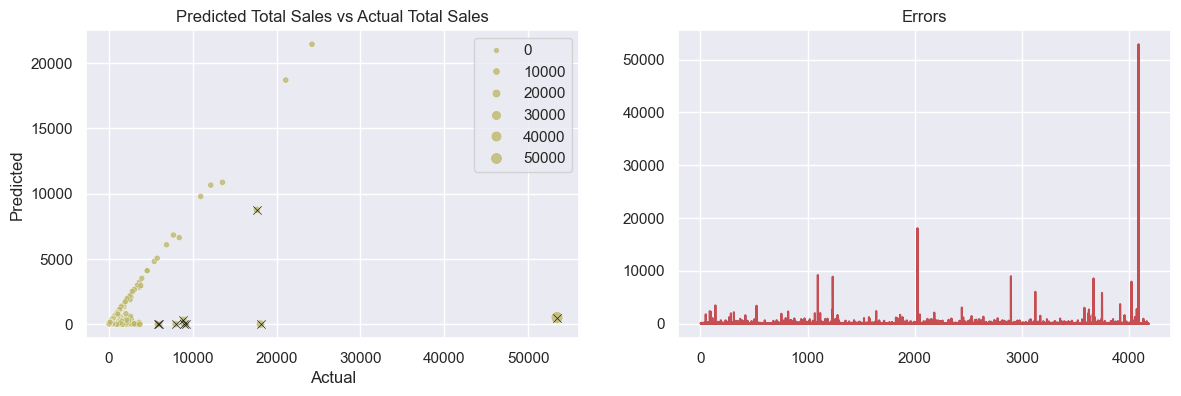

In [128]:
# Predicted v/s Actual
plt.figure(figsize=(14,4))

# Subplot 1: Scatter plot of Predicted vs Actual with Error as size
plt.subplot(121)
sns.scatterplot(x=result["Actual"], y=result["Predicted"], size=result["Error"], color="darkkhaki", alpha=0.8, marker='o')
sns.scatterplot(x=result[result["Error"] > 5000]["Actual"], y=result[result["Error"] > 5000]["Predicted"], color="k", marker="x")
plt.title("Predicted Total Sales vs Actual Total Sales")

# Subplot 2: Plot of Errors
plt.subplot(122)
plt.plot(result["Error"], color="r")
plt.title("Errors")

plt.show()


## Pareto - Negative Binomial Distribution + Gamma Gamma Distribution Model

In [129]:
summary_pnbd = summary.copy()

In [130]:
summary_pnbd.shape

(4185, 5)

In [131]:
pareto_nbd = ParetoNBDFitter(penalizer_coef = 0.0)
pareto_nbd.fit(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

<lifetimes.ParetoNBDFitter: fitted with 4185 subjects, alpha: 87.62, beta: 9262.72, r: 1.43, s: 3.06>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

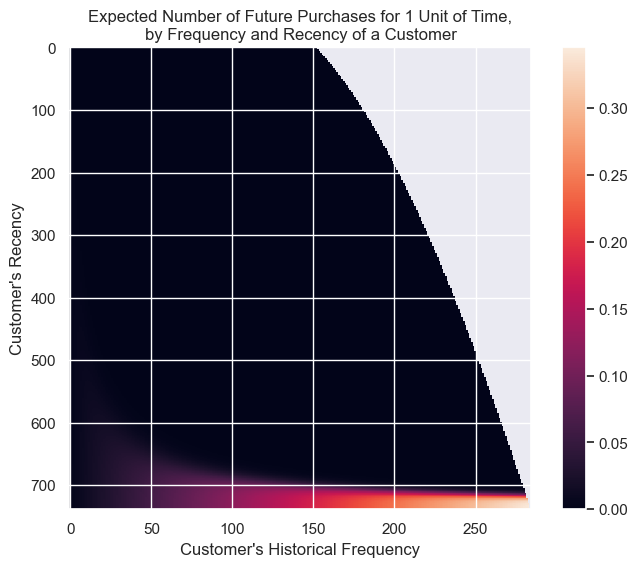

In [132]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(pareto_nbd)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

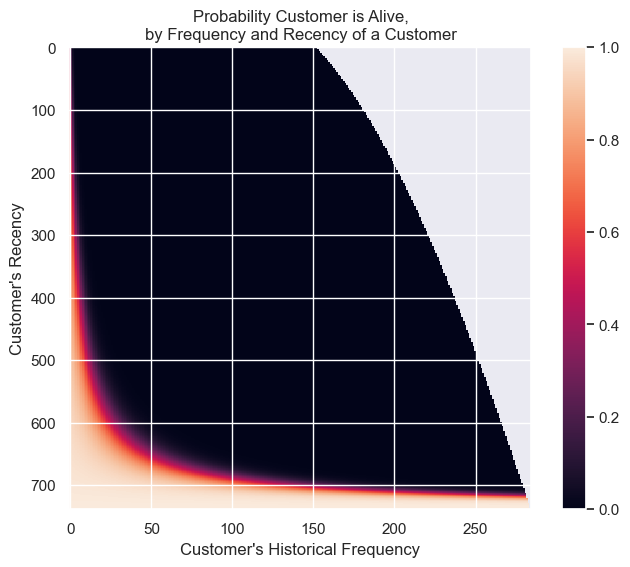

In [133]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(pareto_nbd)

In [134]:
summary_pnbd["p_not_alive"] = 1-pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])
summary_pnbd["p_alive"] = pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

In [135]:
t = 30
summary_pnbd["predicted_purchases"] = pareto_nbd.conditional_expected_number_of_purchases_up_to_time(t, summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

In [136]:
summary_pnbd.sort_values(by = "predicted_purchases").tail(5)

,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
1612,14606.0,181.0,735.0,736.0,165.079448,0.000342,0.999658,6.612400
3910,17841.0,193.0,736.0,737.0,357.437461,0.000345,0.999655,7.038789
2105,15311.0,201.0,738.0,738.0,560.647015,0.000000,1.000000,7.322056
275,12748.0,206.0,735.0,735.0,241.501117,0.000000,1.000000,7.530260
1824,14911.0,284.0,737.0,738.0,948.996127,0.000365,0.999635,10.320430


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

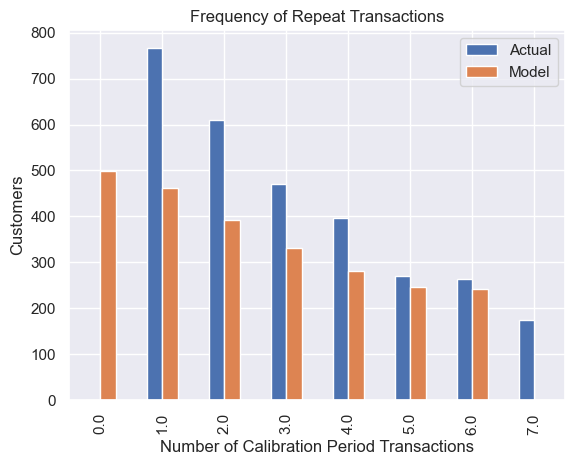

In [137]:
plot_period_transactions(pareto_nbd)

Dividing our dataset into training & holdout

In [138]:
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "Customer ID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [139]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


In [140]:
pareto_nbd.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 5025 subjects, alpha: 63.65, beta: 1209.34, r: 0.82, s: 1.08>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

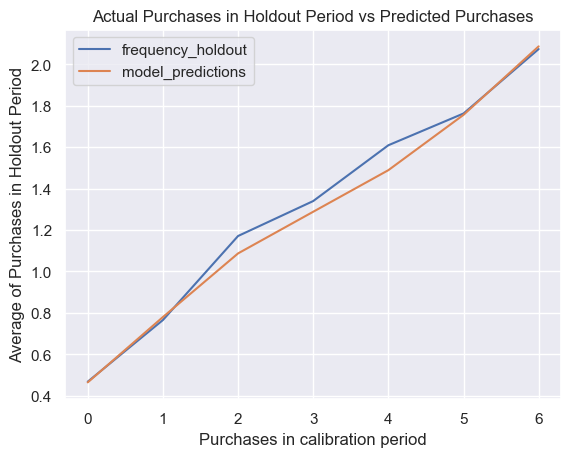

In [141]:
plot_calibration_purchases_vs_holdout_purchases(pareto_nbd, pareto_summary_cal_holdout)

Creating a function which can predict the future purchased value based on the lookup window

In [142]:
def pareto_get_pred_error(t, id_):
    
    individual_p = summary_pnbd[summary_pnbd["Customer ID"] == id_]
    
    ind_pred_p = pareto_nbd.predict(t, individual_p["frequency"], individual_p["recency"], individual_p["T"])
    
    actual_val_p = individual_p["frequency"]/individual_p["recency"]*t
    
    error = actual_val_p - ind_pred_p
    
    print("Your Predicted Purchase: %s" % (ind_pred_p))
    print("Your Actual Purchase: %s" % (actual_val_p))
    print("Prediction Error: %s" % (error))

In [143]:
pareto_get_pred_error(30, 12346.0)

Your Predicted Purchase: Series([], dtype: float64)
Your Actual Purchase: Series([], dtype: float64)
Prediction Error: Series([], dtype: float64)


In [144]:
summary_pnbd["actual_30_p"] = summary_pnbd["frequency"]/summary_pnbd["recency"]*30

In [145]:
summary_pnbd["actual_30_p"].fillna(0, inplace = True)

In [146]:
summary_pnbd["p_error"] = summary_pnbd["actual_30_p"]-summary_pnbd["predicted_purchases"]

In [147]:
print("Mean Squared Error: %s" % mean_squared_error(summary_pnbd["actual_30_p"], summary_pnbd["predicted_purchases"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_pnbd["actual_30_p"], summary_pnbd["predicted_purchases"])))
print("Average Purchase Error: %s" %(summary_pnbd["p_error"].mean()))

Mean Squared Error: 2.4549803348997465
Root Mean Squared Error: 1.5668376862010138
Average Purchase Error: 0.35249356473685856


In [148]:
pareto_mse_purchase = mean_squared_error(summary_pnbd["actual_30_p"], summary_pnbd["predicted_purchases"])
pareto_rmse_purchase = sqrt(mean_squared_error(summary_pnbd["actual_30_p"], summary_pnbd["predicted_purchases"]))
pareto_avg_error_purchase = summary_pnbd["p_error"].mean()

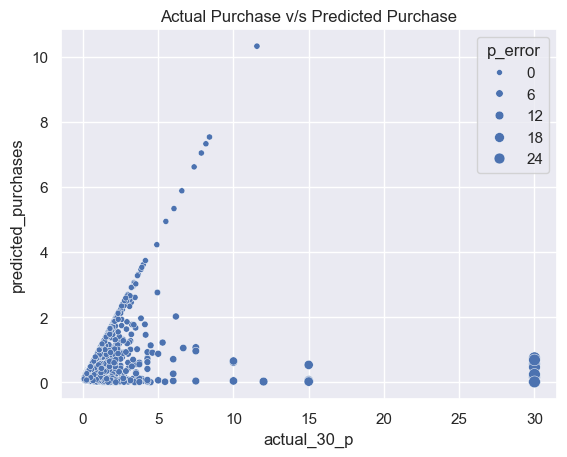

In [149]:
sns.scatterplot(x=summary_pnbd["actual_30_p"], y=summary_pnbd["predicted_purchases"], size = summary_pnbd["p_error"])
plt.title("Actual Purchase v/s Predicted Purchase")
plt.show()

In [164]:
# data["Customer ID"] = pd.to_datetime(data["Customer ID"])
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# data["Customer ID"] = data["Customer ID"].astype(str) 
data["InvoiceDate"] = data["InvoiceDate"].astype(str) 



In [166]:
# Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    individual_alive = data_[data_["Customer ID"] == str(id_)]  # Convert id_ to string
    if individual_alive.empty:
        print("No transactions found for Customer ID {}.".format(id_))
        return
    
    plot_history_alive(pareto_nbd, t=t_, transactions=individual_alive, datetime_col="InvoiceDate", freq="D")



ConversionError: Failed to convert value(s) to axis units: '2010-11-12 10:20:00'

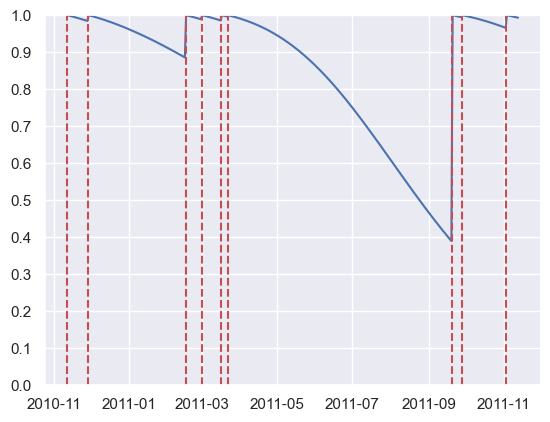

In [169]:
get_history_alive(365, data, '12352.0')

In [170]:
summary_copy = summary_pnbd.copy()

In [171]:
summary_copy = summary_copy[(summary_copy["frequency"] > 0) & (summary_copy["monetary_value"] > 0)]

<Axes: >

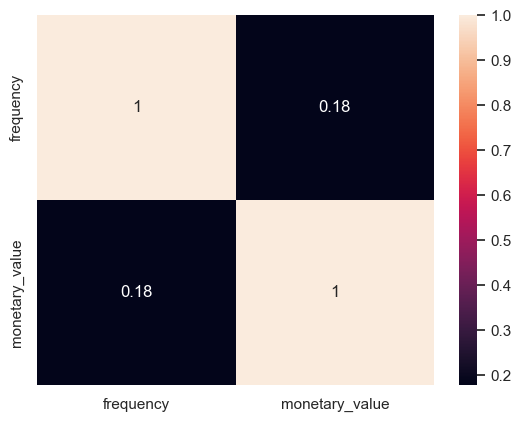

In [172]:
sns.heatmap(summary_copy[["frequency", "monetary_value"]].corr(), annot = True)

In [173]:
ggf_p = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [174]:
ggf_p.fit(summary_copy["frequency"], summary_copy["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 1.37, q: 3.86, v: 696.90>

In [175]:
ggf_p.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.374683,0.058567,1.259892,1.489475
q,3.864415,0.134545,3.600708,4.128123
v,696.904781,50.767856,597.399783,796.409779


In [176]:
summary_copy["expected_avg_sales_p"] = ggf_p.conditional_expected_average_profit(summary_copy["frequency"],
                                                                        summary_copy["monetary_value"])

In [177]:
summary_copy.head()

,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_30_p,p_error,expected_avg_sales_p
0,12347.0,7.0,402.0,404.0,717.398571,0.000644,0.999356,0.511790,0.522388,0.010598,629.556290
1,12348.0,4.0,363.0,438.0,449.310000,0.035907,0.964093,0.297500,0.330579,0.033079,409.972301
2,12349.0,4.0,717.0,735.0,1107.172500,0.005837,0.994163,0.196046,0.167364,-0.028682,842.513995
3,12352.0,8.0,356.0,392.0,218.182500,0.016631,0.983369,0.577418,0.674157,0.096739,242.209404
4,12353.0,1.0,204.0,408.0,89.000000,0.115964,0.884036,0.129529,0.147059,0.017530,254.858476


In [178]:
avg_purchase_error = summary_copy["monetary_value"].mean() - summary_copy["expected_avg_sales_p"].mean()

In [179]:
print("Acutal Avg Sales: %s" % summary_copy["monetary_value"].mean())
print("Predicted Avg Sales: %s" % summary_copy["expected_avg_sales_p"].mean())
print("Mean Sqaured Error: %s" % mean_squared_error(summary_copy["monetary_value"], summary_copy["expected_avg_sales_p"]))
print("Root Mean Sqaured Error: %s" % sqrt(mean_squared_error(summary_copy["monetary_value"], summary_copy["expected_avg_sales_p"])))
print("Avg Sales Error: %s" % avg_purchase_error)

Acutal Avg Sales: 330.6608495198251
Predicted Avg Sales: 340.1889755829264
Mean Sqaured Error: 20896.88188078632
Root Mean Sqaured Error: 144.55753830494734
Avg Sales Error: -9.528126063101297


In [180]:
actual = summary_copy["actual_30_p"] * summary_copy["monetary_value"]
predicted = summary_copy["predicted_purchases"] * summary_copy["expected_avg_sales_p"]

In [181]:
error = actual-predicted

In [182]:
result_p = pd.DataFrame([actual, predicted, error], index = ["Actual", "Predicted", "Error"]).T

In [183]:
print("Average Error: %s" % result_p["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result_p["Actual"], result_p["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result_p["Actual"], result_p["Predicted"])))

Average Error: 105.7184802566418
Mean Squared Error: 915134.2219704059
Root Mean Squared Error: 956.6264798605597


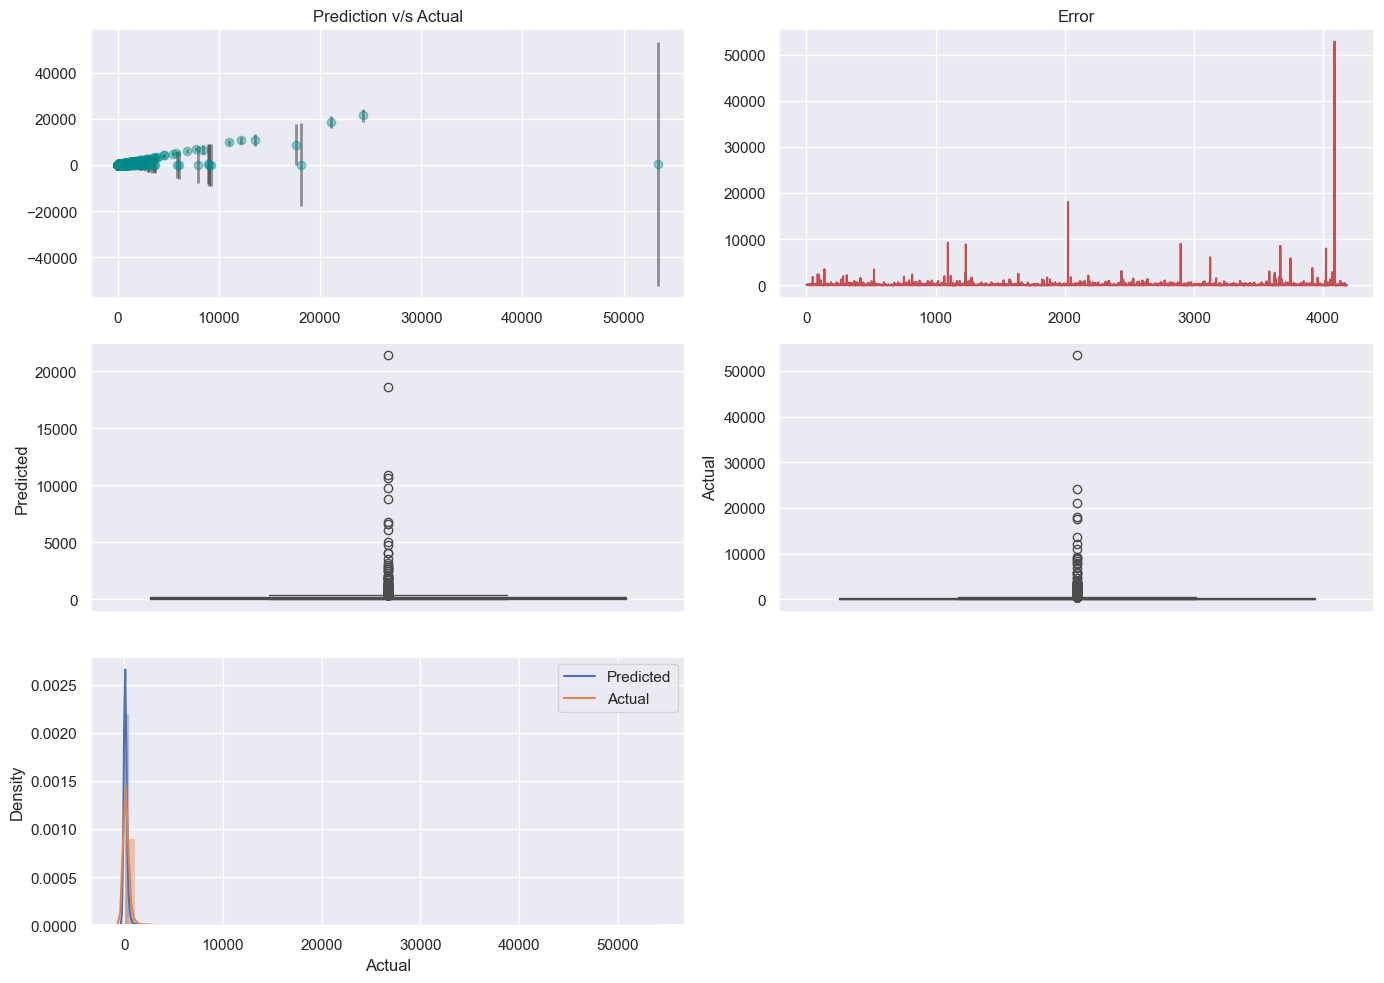

In [187]:
plt.figure(figsize=(14,10))
plt.subplot(321)
plt.errorbar(result_p["Actual"], result_p["Predicted"], yerr=np.abs(result_p["Error"]), fmt='o', color='darkcyan',
             ecolor='black', elinewidth=2, capsize=0, alpha=0.4)
plt.title("Prediction v/s Actual")
plt.subplot(322)
plt.plot(result_p["Error"], color = 'r')
plt.title("Error")
plt.subplot(323)
sns.boxplot(result_p["Predicted"])
plt.subplot(324)
sns.boxplot(result_p["Actual"])
plt.subplot(325)
sns.distplot(result_p["Predicted"])
sns.distplot(result_p["Actual"])
plt.legend(["Predicted", "Actual"])
plt.tight_layout()

In [188]:
summary_copy["predicted_clv_p"] = ggf_p.customer_lifetime_value(pareto_nbd,
                                                       summary_copy["frequency"],
                                                       summary_copy["recency"],
                                                       summary_copy["T"],
                                                       summary_copy["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [189]:
summary_copy.shape

(4185, 12)

In [190]:
summary_copy["CLV_p"] = summary_copy["predicted_clv_p"]*0.05

In [191]:
summary_copy.head()

,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_30_p,p_error,expected_avg_sales_p,predicted_clv_p,CLV_p
0,12347.0,7.0,402.0,404.0,717.398571,0.000644,0.999356,0.511790,0.522388,0.010598,629.556290,6427.062962,321.353148
1,12348.0,4.0,363.0,438.0,449.310000,0.035907,0.964093,0.297500,0.330579,0.033079,409.972301,2243.161458,112.158073
2,12349.0,4.0,717.0,735.0,1107.172500,0.005837,0.994163,0.196046,0.167364,-0.028682,842.513995,3184.463910,159.223195
3,12352.0,8.0,356.0,392.0,218.182500,0.016631,0.983369,0.577418,0.674157,0.096739,242.209404,2760.835994,138.041800
4,12353.0,1.0,204.0,408.0,89.000000,0.115964,0.884036,0.129529,0.147059,0.017530,254.858476,474.568040,23.728402


In [193]:
# with open("summary_copy_pareto_model.pkl", "wb") as fh:
#     pickle.dump(summary_copy, fh)
# with open("summary_copy_bg_nbd_model.pkl", "wb") as fh:
#     pickle.dump(summary_, fh)    

## Modified Beta Geom + Gamma Gamma Distribution Model

In [194]:
summary_mbg = summary.copy()

In [195]:
summary_mbg.head()

,Customer ID,frequency,recency,T,monetary_value
0,12347.0,7.0,402.0,404.0,717.398571
1,12348.0,4.0,363.0,438.0,449.310000
2,12349.0,4.0,717.0,735.0,1107.172500
3,12352.0,8.0,356.0,392.0,218.182500
4,12353.0,1.0,204.0,408.0,89.000000


In [196]:
mbg = ModifiedBetaGeoFitter(penalizer_coef = 0.0)
mbg.fit(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 4185 subjects, a: 0.33, alpha: 82.54, b: 12.61, r: 1.41>

In [197]:
mbg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.405363,0.036067,1.334671,1.476054
alpha,82.544505,2.479380,77.684920,87.404089
a,0.326089,0.047861,0.232281,0.419896
b,12.612666,2.315624,8.074042,17.151290


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

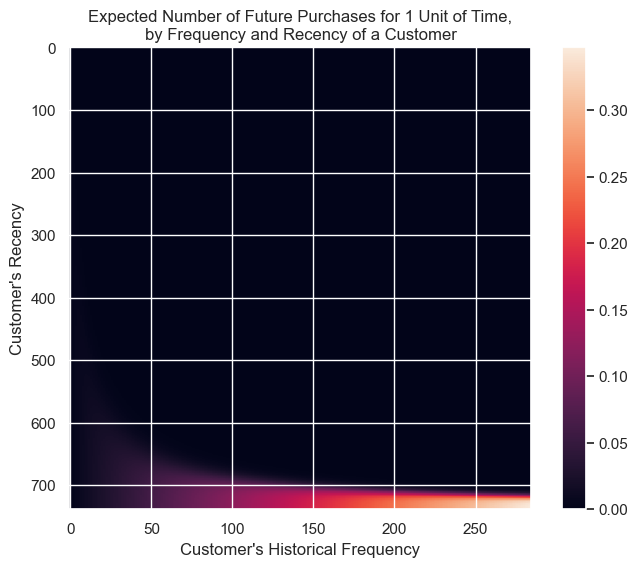

In [198]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(mbg)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

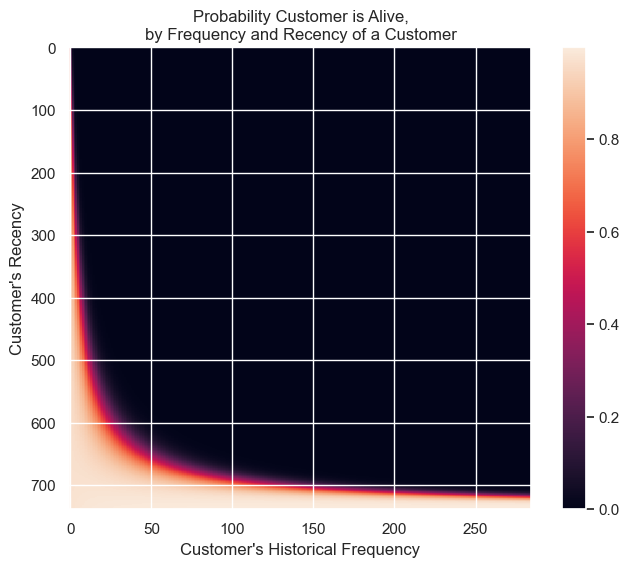

In [199]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(mbg)

In [200]:
t = 30
summary_mbg["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

In [201]:
summary_mbg

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases
0,12347.0,7.0,402.0,404.0,717.398571,0.491299
1,12348.0,4.0,363.0,438.0,449.310000,0.263606
2,12349.0,4.0,717.0,735.0,1107.172500,0.170685
3,12352.0,8.0,356.0,392.0,218.182500,0.558628
4,12353.0,1.0,204.0,408.0,89.000000,0.089547
...,...,...,...,...,...,...
4180,18281.0,1.0,397.0,577.0,80.820000,0.069791
4181,18282.0,2.0,119.0,126.0,38.195000,0.422312
4182,18283.0,18.0,655.0,658.0,146.405556,0.778669
4183,18286.0,2.0,247.0,723.0,362.740000,0.058435


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

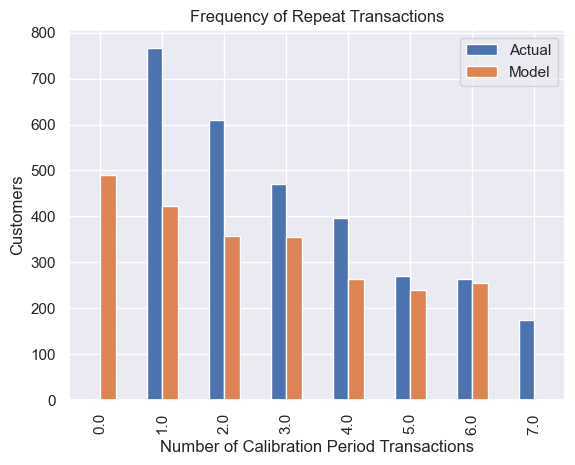

In [202]:
plot_period_transactions(mbg)

Dividing our dataset into training & holdout

In [203]:
summary_cal_holdout = calibration_and_holdout_data(data, "Customer ID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [204]:
mbg.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 5025 subjects, a: 0.28, alpha: 56.91, b: 3.00, r: 0.84>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

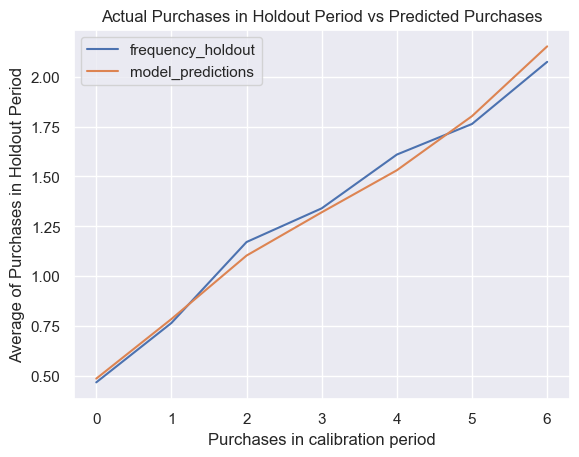

In [205]:
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)

In [206]:
summary_mbg["actual_30"] = summary_mbg["frequency"]/summary_mbg["recency"]*30

In [207]:
summary_mbg = summary_mbg.fillna(value = 0)

In [208]:
summary_mbg.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388
1,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579
2,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364
3,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157
4,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059


In [209]:
summary_mbg["Error"] = summary_mbg["actual_30"] - summary_mbg["predicted_purchases"]

In [210]:
mse = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])

In [211]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_mbg["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 2.4744684978687954
Average Error:  0.372525314697551
Root Mean Squared Error: 1.5730443407192296


In [212]:
mbg_mse_purchase = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])
mbg_rmse_purchase = sqrt(mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"]))
mbg_avg_purchase_error = (summary_mbg["actual_30"].mean() - summary_mbg["predicted_purchases"].mean())

In [213]:
res_summary = summary_mbg[summary_mbg["frequency"] > 0]

In [214]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

<Axes: >

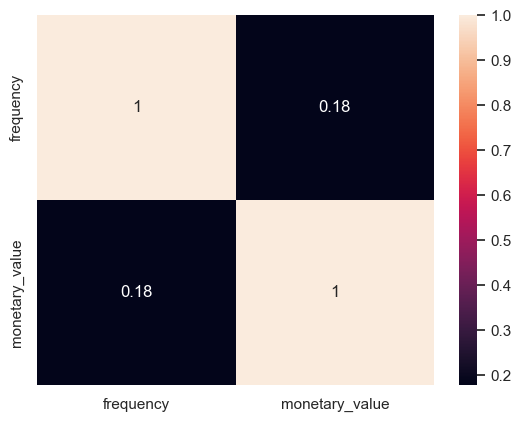

In [215]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

In [216]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [217]:
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 1.37, q: 3.86, v: 696.90>

In [218]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.374683,0.058567,1.259892,1.489475
q,3.864415,0.134545,3.600708,4.128123
v,696.904781,50.767856,597.399783,796.409779


In [219]:
summary_mbg_new = summary_mbg[(summary_mbg["monetary_value"] > 0) & (summary_mbg["frequency"] > 0)]

In [220]:
summary_mbg_new

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089
1,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973
2,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321
3,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529
4,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512
...,...,...,...,...,...,...,...,...
4180,18281.0,1.0,397.0,577.0,80.820000,0.069791,0.075567,0.005776
4181,18282.0,2.0,119.0,126.0,38.195000,0.422312,0.504202,0.081890
4182,18283.0,18.0,655.0,658.0,146.405556,0.778669,0.824427,0.045759
4183,18286.0,2.0,247.0,723.0,362.740000,0.058435,0.242915,0.184480


In [221]:
summary_mbg_new["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_mbg_new["frequency"], 
                                                                        summary_mbg_new["monetary_value"])

In [222]:
summary_mbg_new.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
0,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089,629.556290
1,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973,409.972301
2,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321,842.513995
3,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529,242.209404
4,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512,254.858476


In [223]:
print("Expected Average Sales: %s" % summary_mbg_new["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_mbg_new["monetary_value"].mean())
print("Difference: %s" % (summary_mbg_new["monetary_value"].mean() - summary_mbg_new["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"])))

Expected Average Sales: 340.1889755829264
Actual Average Sales: 330.6608495198251
Difference: -9.528126063101297
Mean Squared Error: 20896.88188078632
Root Mean Squared Error: 144.55753830494734


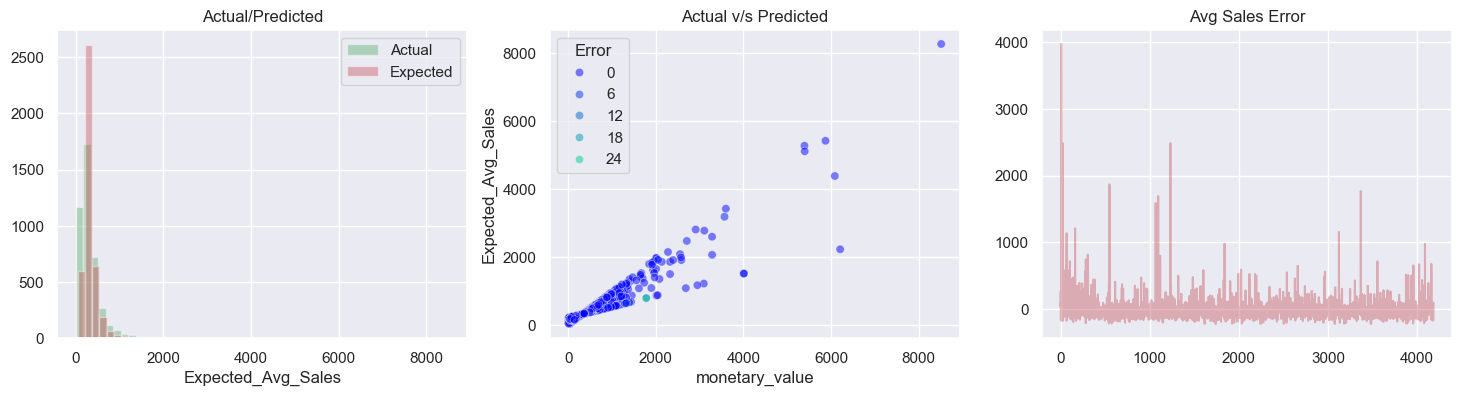

In [225]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(summary_mbg_new["monetary_value"], color = "g", kde = False)
sns.distplot(summary_mbg_new["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(x=summary_mbg_new["monetary_value"], y=summary_mbg_new["Expected_Avg_Sales"], alpha = 0.5, hue = summary_["Error"], palette = "winter")
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(summary_mbg_new["monetary_value"]-summary_mbg_new["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
plt.title("Avg Sales Error")
plt.show()

In [226]:
summary_mbg_new["predicted_clv"] = ggf.customer_lifetime_value(mbg,
                                                       summary_mbg_new["frequency"],
                                                       summary_mbg_new["recency"],
                                                       summary_mbg_new["T"],
                                                       summary_mbg_new["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [227]:
summary_mbg_new

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
0,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089,629.556290,7003.290033
1,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973,409.972301,2522.287420
2,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321,842.513995,3504.589499
3,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529,242.209404,3031.895454
4,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512,254.858476,585.402211
...,...,...,...,...,...,...,...,...,...,...
4180,18281.0,1.0,397.0,577.0,80.820000,0.069791,0.075567,0.005776,252.205811,462.472507
4181,18282.0,2.0,119.0,126.0,38.195000,0.422312,0.504202,0.081890,189.361729,1721.587682
4182,18283.0,18.0,655.0,658.0,146.405556,0.778669,0.824427,0.045759,165.915956,2985.789802
4183,18286.0,2.0,247.0,723.0,362.740000,0.058435,0.242915,0.184480,348.308624,502.273040


In [228]:
summary_mbg_new["CLV"] = summary_mbg_new["predicted_clv"]*0.05

In [229]:
actual = summary_["monetary_value"]*summary_["actual_30"]
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]
error = actual - pred
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [230]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % (mean_squared_error(result["Actual"], result["Predicted"])))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 107.67180305337308
Mean Squared Error: 917392.3395886548
Root Mean Squared Error: 957.8060031074428


In [231]:
summary_mbg_new

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
0,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089,629.556290,7003.290033,350.164502
1,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973,409.972301,2522.287420,126.114371
2,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321,842.513995,3504.589499,175.229475
3,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529,242.209404,3031.895454,151.594773
4,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512,254.858476,585.402211,29.270111
...,...,...,...,...,...,...,...,...,...,...,...
4180,18281.0,1.0,397.0,577.0,80.820000,0.069791,0.075567,0.005776,252.205811,462.472507,23.123625
4181,18282.0,2.0,119.0,126.0,38.195000,0.422312,0.504202,0.081890,189.361729,1721.587682,86.079384
4182,18283.0,18.0,655.0,658.0,146.405556,0.778669,0.824427,0.045759,165.915956,2985.789802,149.289490
4183,18286.0,2.0,247.0,723.0,362.740000,0.058435,0.242915,0.184480,348.308624,502.273040,25.113652


In [232]:
predicted_clv_results = pd.DataFrame(summary_[["Customer ID", "predicted_clv"]])

In [233]:
predicted_clv_results = predicted_clv_results.merge(summary_copy[["Customer ID", "predicted_clv_p"]], on = "Customer ID")

In [239]:
predicted_clv_results.columns = ["Customer ID", "BG-NBD", "Pareto-NBD"]



In [240]:
predicted_clv_results.head(5)

,Customer ID,BG-NBD,Pareto-NBD
0,12347.0,7110.166375,6427.062962
1,12348.0,2512.081673,2243.161458
2,12349.0,3449.798774,3184.463910
3,12352.0,3100.010138,2760.835994
4,12353.0,536.035114,474.568040


##### Purchase Prediction Result Summary

In [244]:
indexes = ["MSE Purchase Error", "RMSE Purchase Error","Avg Purchase Error"]

In [245]:
data = [[bgf_mse_purchase_30, pareto_mse_purchase, mbg_mse_purchase],
[bgf_rmse_purchase_30, pareto_rmse_purchase, mbg_rmse_purchase], [bgf_avg_error_purchase_30, pareto_avg_error_purchase, mbg_avg_purchase_error]]

In [246]:
model_purchase_result = pd.DataFrame(data, columns = ["BG-NBD", "Pareto-NBD", "MBG-NBD"], index = indexes)

In [247]:
model_purchase_result

,BG-NBD,Pareto-NBD,MBG-NBD
MSE Purchase Error,2.475211,2.454980,2.474468
RMSE Purchase Error,1.573280,1.566838,1.573044
Avg Purchase Error,0.359638,0.352494,0.372525


As we can see here is that there is no much difference when it comes to the performance of these models but Pareto NBD model is slightly performing better when it comes it minimizing the MSE & RMSE Errors.